# Getting and Cleaning Data Library Imports

In [1]:
import datetime
import pandas as pd
from influxdb import DataFrameClient
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import pytz
import numpy as np
import yaml
import math
from scipy import stats
from scipy import integrate


import seaborn as sns
import matplotlib.mlab as mlab
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline

# Importing Data into Dataframes
power_df, weather_df, temperature_df, dr_df, rtac_df, setpoint_df, net_power_df

In [2]:
with open('config.yaml') as fp:
    config = yaml.safe_load(fp)
database_config = config.get('database')

In [3]:
with open('uuid_map.json') as fp:
    uuid_map = json.load(fp)

In [4]:
client = DataFrameClient(
    host=database_config.get('host'), 
    port=database_config.get('port'), 
    username=database_config.get('username'), 
    password=database_config.get('password'), 
    database=database_config.get('database'), 
    ssl=database_config.get('ssl'), 
    verify_ssl=database_config.get('verify_ssl')
)

In [5]:
client = DataFrameClient(host='lbnl-solarplus-store.lbl.gov' , port=9003, username= 'xbos_user', password= 'xbos_data_store', database='xbos', ssl=True, verify_ssl=True)

In [6]:
tz_local = pytz.timezone('America/Los_Angeles')
tz_utc = pytz.timezone('UTC')

In [7]:
uuid_dict = {
    'building_power': uuid_map['xbos/wattnode/building_main/PowerSum'], #watts
    'freezer_power': uuid_map['xbos/wattnode/fre_comp_evapfan/PowerSum'],
    'ref_comp_power': uuid_map['xbos/wattnode/ref_comp/PowerSum'],
    'ref_fan_power': uuid_map['xbos/wattnode/ref_evapfan/PowerSum'],
    'hvac_west_power': uuid_map['xbos/wattnode/hvac_west_comp/PowerSum'],
    'hvac_east_power': uuid_map['xbos/wattnode/hvac_east_comp/PowerSum'],
    
    'east_temperature': uuid_map['xbos/flexstat/thermostat_east/space_temp'], #F
    'west_temperature': uuid_map['xbos/flexstat/thermostat_west/space_temp'],
    'freezer_temperature': uuid_map['xbos/parker/freezer/CabinetTemperature'],
    'ref_temperature': uuid_map['xbos/parker/refrigerator/CabinetTemperature'],
    
    'east_heating_sp': uuid_map['xbos/flexstat/thermostat_east/active_heating_setpt'], #F
    'east_cooling_sp': uuid_map['xbos/flexstat/thermostat_east/active_cooling_setpt'],
    'west_heating_sp': uuid_map['xbos/flexstat/thermostat_west/active_heating_setpt'],
    'west_cooling_sp': uuid_map['xbos/flexstat/thermostat_west/active_cooling_setpt'],
    'freezer_sp': uuid_map['xbos/parker/freezer/Setpoint'],
    'ref_sp': uuid_map['xbos/parker/refrigerator/Setpoint'],
    
    'soc_battery': '0efc4fa5-755c-5c45-863a-c0c776ab7538', #0-1
    'setpoint_battery': '276ea28f-0f74-5b3e-9ad1-f3b9f747dbe4', #watts
    'pv_generation_battery': 'fdfd7bbb-d2da-5b11-a8fa-58b231ab9802', #watts
    # below is real battery, above simulated

    
    'oat_current': 'f7c1f2c8-c996-528c-ab3d-bdc96dc9cf72', #F
    'humidity_current': '7967b372-2699-57e1-bc15-7861bfe6d024',#0-100%
    'windspeed_current': 'ac555599-0403-5bea-8441-f39a4e8e0dac', # m/s
    'cloudcover_current': '6cce3e9a-3822-551b-b13c-f4b874f3afa1', # 0-1, 1 being cloudy
    'solar_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',    #watt/m^2
    
    'oat_forecast': '69be4db0-48f5-592f-b5a1-e2e695f28ad1', #as above, forecast predicts next 48 hours
    'humidity_forecast': 'c2379487-3df3-5bfe-bd8d-5992d2381ed5',
    'windspeed_forecast': '837d0588-b30a-56ee-920f-cf366fa0871f',
    'cloudcover_forecast': '6f93857f-50a6-5b9f-8b94-0231f511b382',
    'solar_forecast': 'a8357adb-c59d-5316-a0e8-51d2b2948c75',
    
    'price_energy_dr': '3be4c234-a38a-5e73-9d53-4503751592be', #$/kW*Hours
    'price_demand_dr': '90928e8d-df40-5e75-9ddb-7ee444bc187f', #$/kW
    'pmax_dr': '522605a9-77b1-57e3-9fac-06dd83ab8e89', #maximum power for mpc +999999, changes during demand response events
    'pmin_dr': '6b42adf8-3a48-5ae7-bdc3-19226e602865', #min power, default is -999999
    
    'pv_generation_rtac': 'd4102860-1f55-5e14-b02d-8bdb9e987676', #Watts, real PV generation
    'soc_rtac': '944a5aba-8c59-586e-af87-d95151596cf1', # real state of charge %
    'total_capacity_rtac': 'b55d3081-4678-55ec-9545-bbbcfd544c1f', #watt-hours; move to rtac because real values
    'current_stored_energy_rtac': 'b5619f4e-b83d-567c-a197-254d36a9e885',#watt-hours
    'building_draw_rtac': uuid_map['xbos/wattnode/building_main/PowerSum'],#building_power
}

In [8]:
def parse_dt_utc(dt):
    return tz_local.localize(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

In [9]:
def current_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [10]:
def forecast_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and \"prediction_step\" = '1' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [11]:
def get_data_section(client, endswith, st, et, uuid_dict, resample='1T', current=True):
    df_list = []
    for variable in uuid_dict:
        if variable.endswith(endswith):
            uuid = uuid_dict[variable]
            if current:
                df = current_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            else:
                df = forecast_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            df = df.resample(resample).mean()
            df_list.append(df)
    return pd.concat(df_list, axis=1)

In [12]:
st = "2020-08-17 00:00:00"
et = "2020-08-23 23:59:59"

In [13]:
power_df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
power_df = power_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
power_df.head()
power_df['total']=power_df.sum(axis=1)
power_df.head()


building      freezer     ref_comp     ref_fan  \
2020-08-17 00:00:00  31805.438281  2407.208877   569.662086  143.268786   
2020-08-17 00:30:00  36953.611589  4088.444576   435.057029   68.805714   
2020-08-17 01:00:00  37066.349089  3987.043433  1412.689012  329.387041   
2020-08-17 01:30:00  35921.825553  3226.991329  1563.182641  321.804926   
2020-08-17 02:00:00  34096.109701  3108.643667  1615.347333  308.327506   

                       hvac_west    hvac_east         total  
2020-08-17 00:00:00   361.158451  3943.490527  39230.227008  
2020-08-17 00:30:00  1859.208396  3925.219495  47330.346798  
2020-08-17 01:00:00  3062.440495  3600.150389  49458.059457  
2020-08-17 01:30:00  3064.328723  2907.778809  47005.911980  
2020-08-17 02:00:00  2255.195428  2154.600018  43538.223652

In [14]:
setpoint_df = get_data_section(client, '_sp', st, et, uuid_dict, '1T')
setpoint_df = setpoint_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
setpoint_df.head()

east_heating  east_cooling  west_heating  west_cooling  \
2020-08-17 00:00:00          68.0          70.0          68.0          70.0   
2020-08-17 00:30:00          68.0          70.0          68.0          70.0   
2020-08-17 01:00:00          68.0          70.0          68.0          70.0   
2020-08-17 01:30:00          68.0          70.0          68.0          70.0   
2020-08-17 02:00:00          68.0          70.0          68.0          70.0   

                     freezer   ref  
2020-08-17 00:00:00     -7.0  33.0  
2020-08-17 00:30:00     -7.0  33.0  
2020-08-17 01:00:00     -7.0  33.0  
2020-08-17 01:30:00     -7.0  33.0  
2020-08-17 02:00:00     -7.0  33.0

In [15]:
temperature_df = get_data_section(client, '_temperature', st, et, uuid_dict, '1T')
temperature_df = temperature_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
temperature_df.head()

east       west    freezer        ref
2020-08-17 00:00:00  72.557665  70.108999  35.533333  36.166667
2020-08-17 00:30:00  72.700998  70.909999  -0.633333  39.133333
2020-08-17 01:00:00  70.710665  70.918832  -4.366667  34.633333
2020-08-17 01:30:00  70.547665  70.544999  -5.300000  34.700000
2020-08-17 02:00:00  70.492664  70.138499  -5.150000  34.733333

In [16]:
battery_df = get_data_section(client, '_battery', st, et, uuid_dict, '1T')
battery_df = battery_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
battery_df.head()

soc  setpoint  pv_generation
2020-08-17 00:00:00  0.454662         0            0.0
2020-08-17 00:30:00  0.454153         0            0.0
2020-08-17 01:00:00  0.454153         0            0.0
2020-08-17 01:30:00  0.454153         0            0.0
2020-08-17 02:00:00  0.452625         0            0.0

In [17]:
weather_df = get_data_section(client, '_current', st, et, uuid_dict, '1T')
weather_df = weather_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
weather_df.head()

oat    humidity  windspeed  cloudcover  solar
2020-08-17 00:00:00  63.080545   99.063636   1.418727    0.628818    0.0
2020-08-17 00:30:00  62.917467   99.920000   1.599200    0.693733    0.0
2020-08-17 01:00:00  62.768867  100.000000   1.651133    0.781733    0.0
2020-08-17 01:30:00  62.550933  100.000000   1.691800    0.820267    0.0
2020-08-17 02:00:00  62.213267  100.000000   1.920800    0.855400    0.0

In [18]:
rtac_df = get_data_section(client, '_rtac', st, et, uuid_dict, '1T')
rtac_df = rtac_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
rtac_df.head()

pv_generation       soc  total_capacity  \
2020-08-17 00:00:00            0.0  0.938097   165727.633333   
2020-08-17 00:30:00            0.0  0.908577   160202.800000   
2020-08-17 01:00:00            0.0  0.657895   116009.600000   
2020-08-17 01:30:00            0.0  0.845775   149155.200000   
2020-08-17 02:00:00            0.0  0.939814   165728.000000   

                     current_stored_energy  building_draw  
2020-08-17 00:00:00          155468.566667   31805.438281  
2020-08-17 00:30:00          150575.833333   36953.611589  
2020-08-17 01:00:00          109031.600000   37066.349089  
2020-08-17 01:30:00          140168.600000   35921.825553  
2020-08-17 02:00:00          155753.533333   34096.109701

In [19]:
dr_df = get_data_section(client, '_dr', st, et, uuid_dict, '60T', current=False)
dr_df = dr_df.tz_convert(tz_local).tz_localize(None).resample('1T').fillna(method='ffill')
dr_df.head()

price_energy  price_demand    pmax    pmin
2020-08-17 00:00:00       0.04026           0.0  999999 -999999
2020-08-17 00:01:00       0.04026           0.0  999999 -999999
2020-08-17 00:02:00       0.04026           0.0  999999 -999999
2020-08-17 00:03:00       0.04026           0.0  999999 -999999
2020-08-17 00:04:00       0.04026           0.0  999999 -999999

# Data Cleaning

### Check For Missing Data 
(Checks if there are indices with no datapoints, resampling means no missing data I think)

In [20]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [21]:
def get_heatmap(df):
    cols = df.columns
    colors = ['#000080', '#ffd700']
    sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors)) #navy data is there, gold is not (go bears)

In [22]:
def missing_data_percent(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [23]:
dfs=[power_df,setpoint_df,temperature_df, battery_df, weather_df, rtac_df, dr_df]

In [24]:
for df in dfs:
    print('                 '+get_df_name(df))
    missing_data_percent(df)

                 power_df
building - 0.0%
freezer - 0.0%
ref_comp - 0.0%
ref_fan - 0.0%
hvac_west - 0.0%
hvac_east - 0.0%
total - 0.0%
                 setpoint_df
east_heating - 0.0%
east_cooling - 0.0%
west_heating - 0.0%
west_cooling - 0.0%
freezer - 0.0%
ref - 0.0%
                 temperature_df
east - 0.0%
west - 0.0%
freezer - 0.0%
ref - 0.0%
                 battery_df
soc - 0.0%
setpoint - 0.0%
pv_generation - 0.0%
                 weather_df
oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%
                 rtac_df
pv_generation - 0.0%
soc - 0.0%
total_capacity - 0.0%
current_stored_energy - 0.0%
building_draw - 0.0%
                 dr_df
price_energy - 0.0%
price_demand - 0.0%
pmax - 0.0%
pmin - 0.0%


In [25]:
missing_data_percent(weather_df)

oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%


### Removing Outliers
Check outliers by plotting, looking at stats using .describe(), and boxplotting.
Removing numeric outliers based on iqr and zscore. Using iqr cleaned data later on because zscore doesn't work when std=0

#### Functions for checking and removing outliers

In [26]:
#User Preferences
tol=1.5 #the amount of interquartile ranges a value can be from the first or third quartile

In [27]:
def check(df):
    print(get_df_name(df))
    #df.plot()
    #plt.show()
    df.boxplot()
    plt.show()
    #display(df.describe())

In [28]:
#making copy of uncleaned and returning cleaned, can flip
def remove_quantile_outliers(df):
    new_df=df.copy()
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1   
        filter = (df[col] >= q1-tol*iqr) & (df[col] <= q3+tol*iqr)
        new_df[col]=df[col].loc[filter] 
    return new_df

In [29]:
def copy_dfs(dfs):
    copy_dfs={}
    for df in dfs:
        copy_dfs[get_df_name(df)]=df.copy()
    return copy_dfs
    

In [30]:
def remove_on_zscore(df):
    z=df.apply(stats.zscore)
    return df[np.abs(z) < 3]

#### checking boxplots for iqr removal and cleaning using iqr

power_df


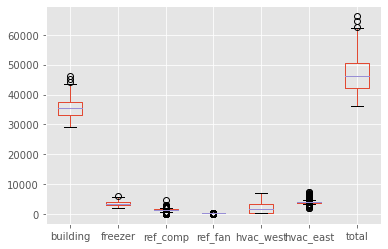

setpoint_df


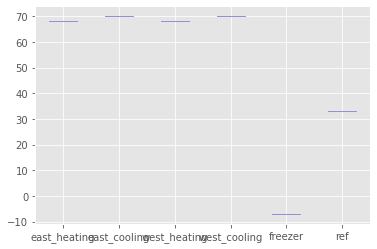

temperature_df


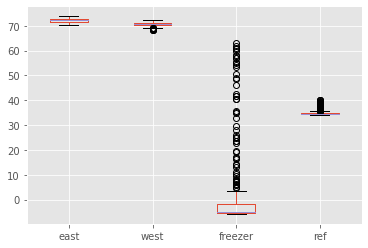

battery_df


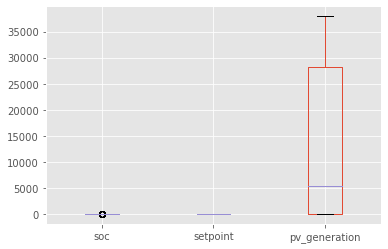

weather_df


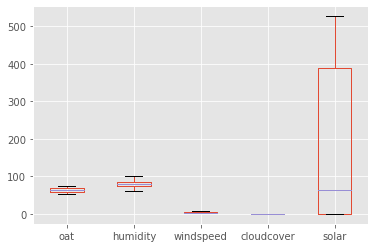

rtac_df


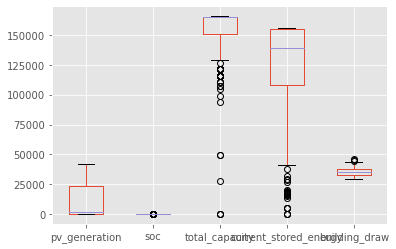

dr_df


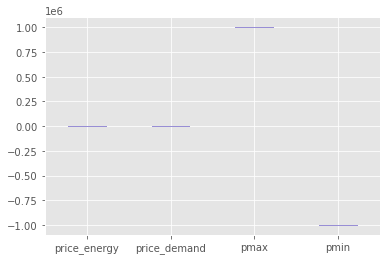

In [31]:
for df in dfs:
    check(df)

In [32]:
plt.rcParams["figure.figsize"] = (8,8)

In [33]:
cleaned_dfs={}

In [34]:
for df in dfs:
    cleaned_dfs[get_df_name(df)]=remove_quantile_outliers(df)

df


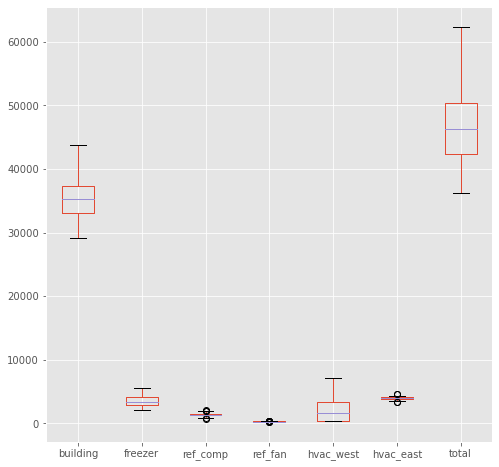

df


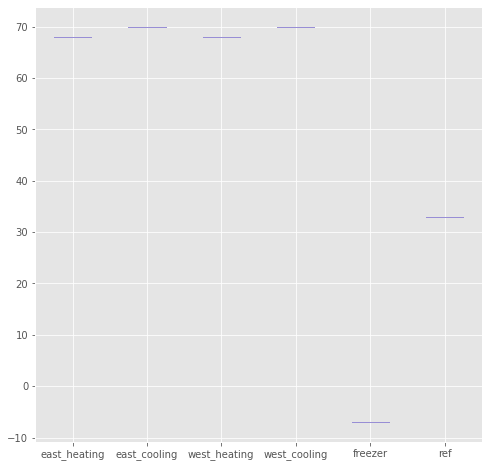

df


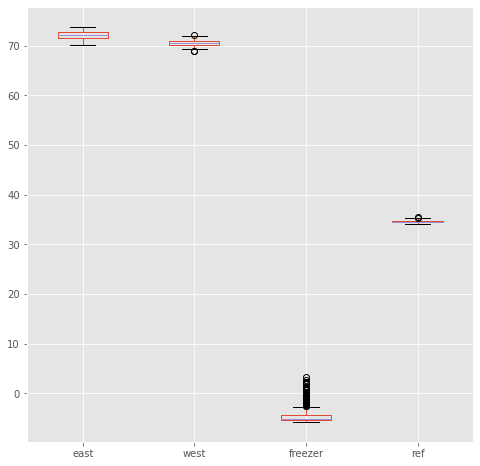

df


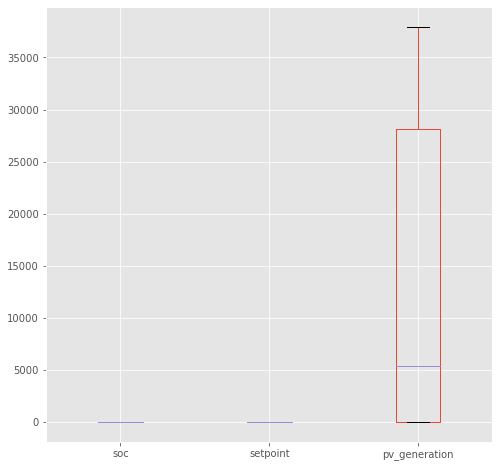

df


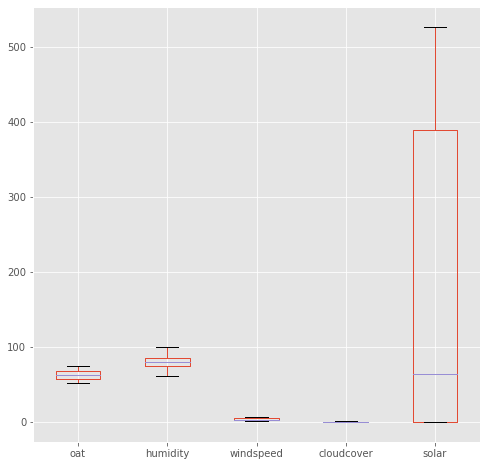

df


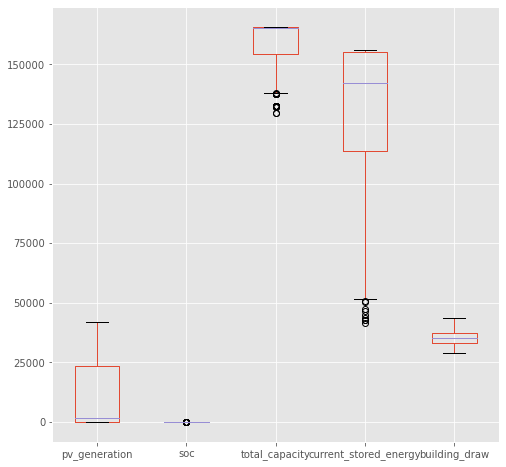

df


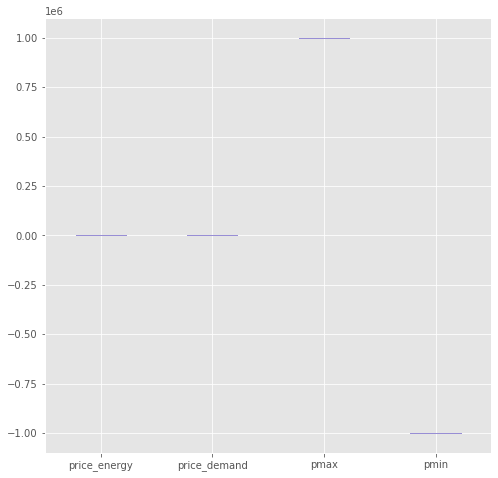

In [35]:
for df in cleaned_dfs.values():
    check(df)

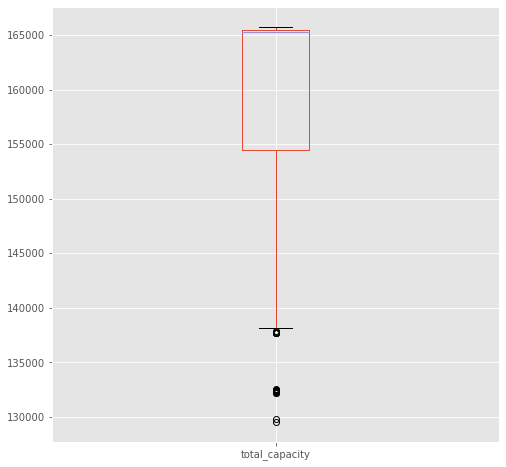

In [36]:
cleaned_dfs['rtac_df'][['total_capacity']].boxplot()

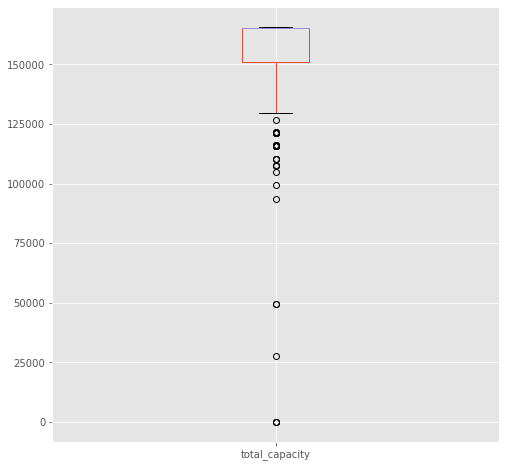

In [37]:
rtac_df[['total_capacity']].boxplot()

#### checking datapoints removed for iqr removal and comparing with zscore

In [38]:
for df in dfs:
    missing_data_percent(df)

building - 0.0%
freezer - 0.0%
ref_comp - 0.0%
ref_fan - 0.0%
hvac_west - 0.0%
hvac_east - 0.0%
total - 0.0%
east_heating - 0.0%
east_cooling - 0.0%
west_heating - 0.0%
west_cooling - 0.0%
freezer - 0.0%
ref - 0.0%
east - 0.0%
west - 0.0%
freezer - 0.0%
ref - 0.0%
soc - 0.0%
setpoint - 0.0%
pv_generation - 0.0%
oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%
pv_generation - 0.0%
soc - 0.0%
total_capacity - 0.0%
current_stored_energy - 0.0%
building_draw - 0.0%
price_energy - 0.0%
price_demand - 0.0%
pmax - 0.0%
pmin - 0.0%


In [39]:
for df in cleaned_dfs.values():
    missing_data_percent(df)

building - 1.0%
freezer - 0.0%
ref_comp - 15.0%
ref_fan - 12.0%
hvac_west - 0.0%
hvac_east - 11.0%
total - 1.0%
east_heating - 0.0%
east_cooling - 0.0%
west_heating - 0.0%
west_cooling - 0.0%
freezer - 0.0%
ref - 0.0%
east - 0.0%
west - 6.0%
freezer - 16.0%
ref - 13.0%
soc - 6.0%
setpoint - 0.0%
pv_generation - 0.0%
oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%
pv_generation - 0.0%
soc - 7.0%
total_capacity - 9.0%
current_stored_energy - 7.0%
building_draw - 1.0%
price_energy - 0.0%
price_demand - 0.0%
pmax - 0.0%
pmin - 0.0%


In [40]:
zscore_dfs={}

In [41]:
#ignoring  RuntimeWarning: invalid value encountered in less
for df in dfs:
    zscore_dfs[get_df_name(df)]=remove_on_zscore(df)

/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [42]:
for df in zscore_dfs.values():
    missing_data_percent(df)

building - 1.0%
freezer - 0.0%
ref_comp - 1.0%
ref_fan - 4.0%
hvac_west - 0.0%
hvac_east - 4.0%
total - 1.0%
east_heating - 100.0%
east_cooling - 100.0%
west_heating - 100.0%
west_cooling - 100.0%
freezer - 100.0%
ref - 100.0%
east - 0.0%
west - 1.0%
freezer - 5.0%
ref - 4.0%
soc - 6.0%
setpoint - 100.0%
pv_generation - 0.0%
oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%
pv_generation - 0.0%
soc - 0.0%
total_capacity - 2.0%
current_stored_energy - 0.0%
building_draw - 1.0%
price_energy - 0.0%
price_demand - 0.0%
pmax - 100.0%
pmin - 100.0%


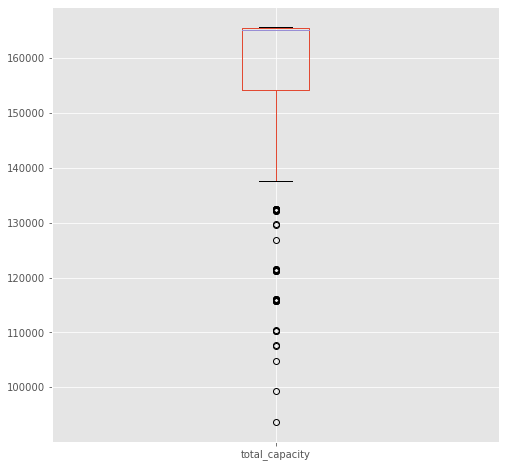

In [43]:
zscore_dfs['rtac_df'][['total_capacity']].boxplot()

### Cleaning SOC%
Addressing the spikiness in the SOC by interpolating when the total_capacity value is an outlier. (NaN now because those values have been removed). 

In [44]:
# if multiple NaN values, split dataframe then check for first non-null index and use that, or iterate in for loop if null. iterate in for loop may be better since double NaN's are uncommon

In [45]:
def intp_on_null(df,NullCol,interpCols):
#     top_ind = df[nan_inds[i]:, :].first_valid_index()
#     bot_ind = df[:nan_ind[i], :].iloc[::-1].first_valid_index() #::-1 reverses it but I don't understand how
#     top_val=df[col][top_ind]
#     bot_val=df[col][bot_ind]
#     m=(top_val-bot_val)/
#     battery_df[col][nan_inds[i]]=
    dfn=df.copy()
    nan_inds=dfn.index[dfn[NullCol].isnull()]
    dfn[interpCols][nan_inds]=np.NaN
    return dfn.interpolate()
    

In [46]:
def Egap(df):
    ptol=0
    tol=0
    if ((abs(df['Pbal']) > ptol) & (df['dBatt'] < ( (1+tol) * df['current_stored_energy'] )) & (~np.isnan(df['Pbal']))&(~np.isnan(df['dBatt']))):
                                    

        df['Egap']=df['Pbal']  #lost potential. Positive number means excess power generated that couldn't be stored, negative means draw from generator or grid
    # this neglects the possible profit from returning power to grid vs charging battery (would this ever be the case??)

In [47]:
def PowerCols(df):
    df['post_clean_soc']=df['current_stored_energy']/df['total_capacity']
    df['clean_constant_capacity_soc']=df['current_stored_energy']/(174*10**3)

    #choosing an absolute value based on looking at the data, probably a more rhigorous way to do this, but composite probs useless
    df['composite_soc']=df['post_clean_soc']
    comp_inds=df.index[df['post_clean_soc']<0.45]
    df['composite_soc'][comp_inds]=df['clean_constant_capacity_soc'][comp_inds]
    
    #probs need to model battery to get a more accurate/useful power balance
    df['deltaP']=df['pv_generation']-df['building_draw']
    df['dBatt']=df['current_stored_energy'].diff()    
    df['Pbal']=df['dBatt']+df['deltaP'] #system scale power balance
    
#     if ((abs(df['Pbal']) > ptol) & ((df['dBatt'] < ( (1+tol) * df['current_stored_energy'] )) & ( df['dBatt'] > ( (1+tol)* df['current_stored_energy'] ) )) ):
#         df['Egap']=df['Pbal']  #lost potential. Positive number means excess power generated that couldn't be stored, negative means draw from generator or grid
    
#    df['Egap']=df.apply(Egap, axis=1)
    #df['PowerFromGrid']=
    
    return df
    
    

In [48]:

PowerBal_df=PowerCols(intp_on_null(cleaned_dfs['rtac_df'],'total_capacity','current_stored_energy'))
PowerBal_df.head(10)

pv_generation       soc  total_capacity  \
2020-08-17 00:00:00            0.0  0.938097   165727.633333   
2020-08-17 00:30:00            0.0  0.908577   160202.800000   
2020-08-17 01:00:00            0.0  0.657895   154679.000000   
2020-08-17 01:30:00            0.0  0.845775   149155.200000   
2020-08-17 02:00:00            0.0  0.939814   165728.000000   
2020-08-17 02:30:00            0.0  0.939916   165728.000000   
2020-08-17 03:00:00            0.0  0.939604   165728.666667   
2020-08-17 03:30:00            0.0  0.657955   165729.300000   
2020-08-17 04:00:00            0.0  0.939510   165729.933333   
2020-08-17 04:30:00            0.0  0.657933   165729.933333   

                     current_stored_energy  building_draw  post_clean_soc  \
2020-08-17 00:00:00          155468.566667   31805.438281        0.938097   
2020-08-17 00:30:00          150575.833333   36953.611589        0.939908   
2020-08-17 01:00:00          145372.216667   37066.349089        0.939832   
2020-08-17 01:30:00          140168.600000   35921.825553        0.939750   
2020-08-17 02:00:00          155753.533333   34096.109701        0.939814   
2020-08-17 02:30:00          155770.333333   34136.724251        0.939916   
2020-08-17 03:00:00          155719.300000   34413.888607        0.939604   
2020-08-17 03:30:00          155712.150000   33708.721484        0.939557   
2020-08-17 04:00:00          155705.000000   36588.538835        0.939510   
2020-08-17 04:30:00          155731.991667   34175.239453        0.939673   

                     clean_constant_capacity_soc  composite_soc        deltaP  \
2020-08-17 00:00:00                     0.893498       0.938097 -31805.438281   
2020-08-17 00:30:00                     0.865378       0.939908 -36953.611589   
2020-08-17 01:00:00                     0.835473       0.939832 -37066.349089   
2020-08-17 01:30:00                     0.805567       0.939750 -35921.825553   
2020-08-17 02:00:00                     0.895135       0.939814 -34096.109701   
2020-08-17 02:30:00                     0.895232       0.939916 -34136.724251   
2020-08-17 03:00:00                     0.894939       0.939604 -34413.888607   
2020-08-17 03:30:00                     0.894897       0.939557 -33708.721484   
2020-08-17 04:00:00                     0.894856       0.939510 -36588.538835   
2020-08-17 04:30:00                     0.895011       0.939673 -34175.239453   

                            dBatt          Pbal  
2020-08-17 00:00:00           NaN           NaN  
2020-08-17 00:30:00  -4892.733333 -41846.344922  
2020-08-17 01:00:00  -5203.616667 -42269.965755  
2020-08-17 01:30:00  -5203.616667 -41125.442220  
2020-08-17 02:00:00  15584.933333 -18511.176367  
2020-08-17 02:30:00     16.800000 -34119.924251  
2020-08-17 03:00:00    -51.033333 -34464.921940  
2020-08-17 03:30:00     -7.150000 -33715.871484  
2020-08-17 04:00:00     -7.150000 -36595.688835  
2020-08-17 04:30:00     26.991667 -34148.247786

# Plotting and Data Analysis

### SOC and Net Power Balance Plotting and Analysis
PowerBal_df, w2PowerBal_df

#### How SOC appears on a weekly basis

In [49]:
#secondary week for comparison
w2st = "2020-08-10 00:00:00"
w2et = "2020-08-16 23:59:59"

In [50]:
#changes general sizes and spacings, size and spacings for title and subtitles done n assigning loops    
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelpad'] = 10
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 14})

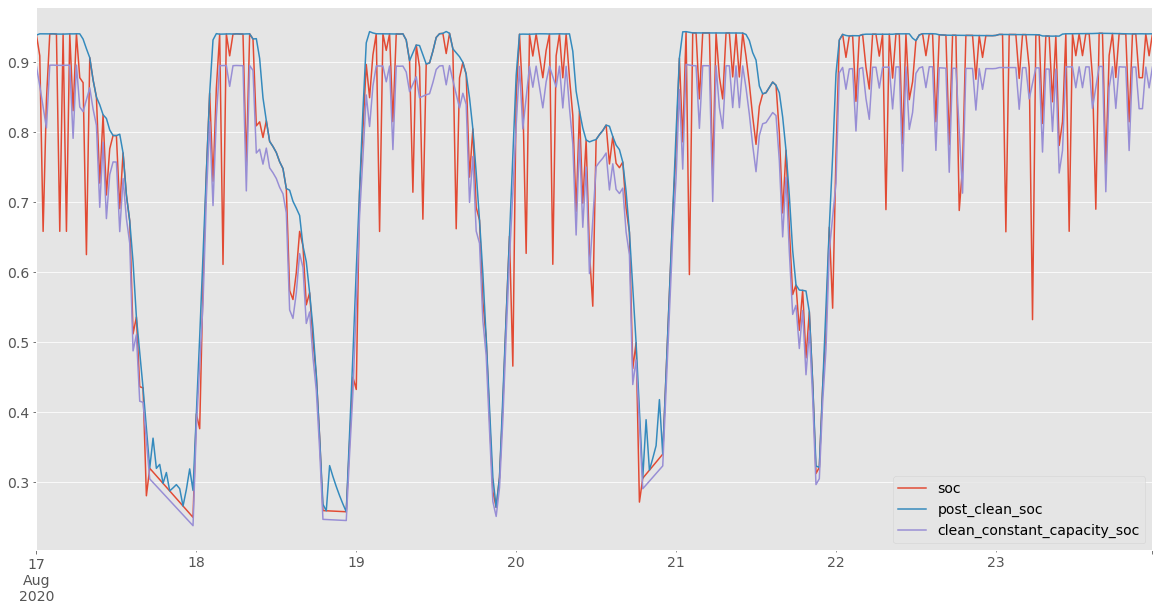

In [51]:
PowerBal_df[['soc','post_clean_soc','clean_constant_capacity_soc']].plot()

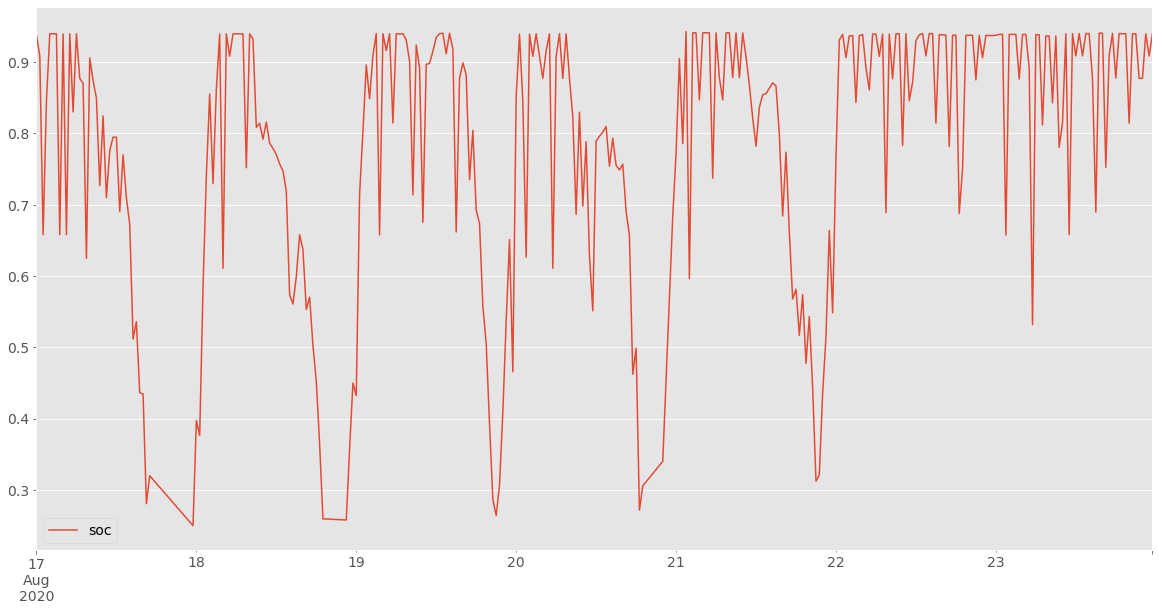

In [52]:
PowerBal_df[['soc']].plot()

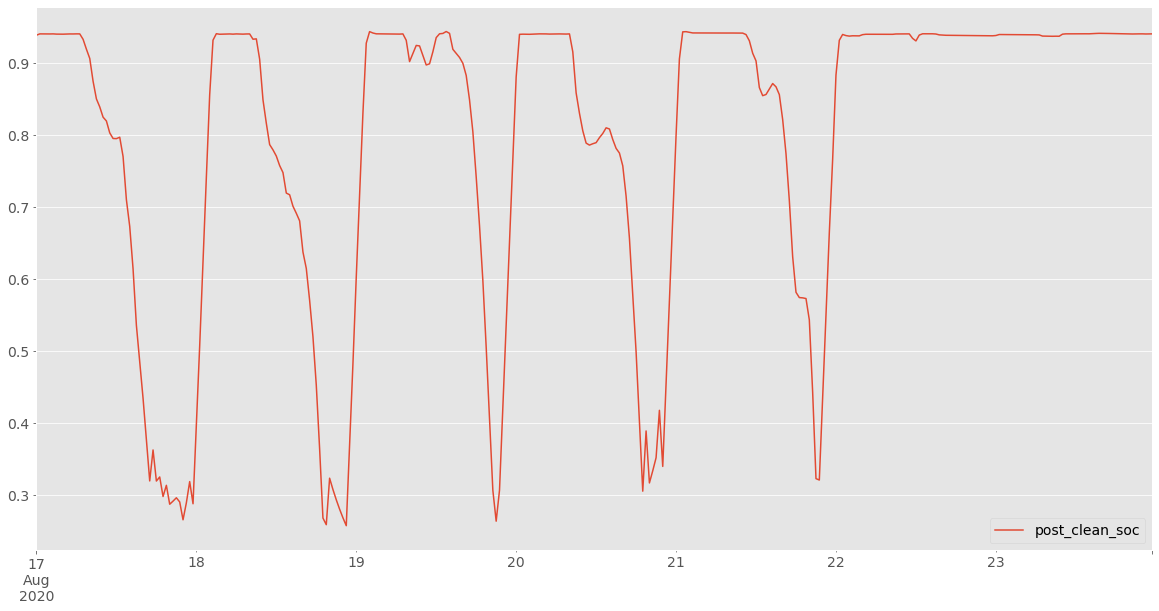

In [53]:
PowerBal_df[['post_clean_soc']].plot()

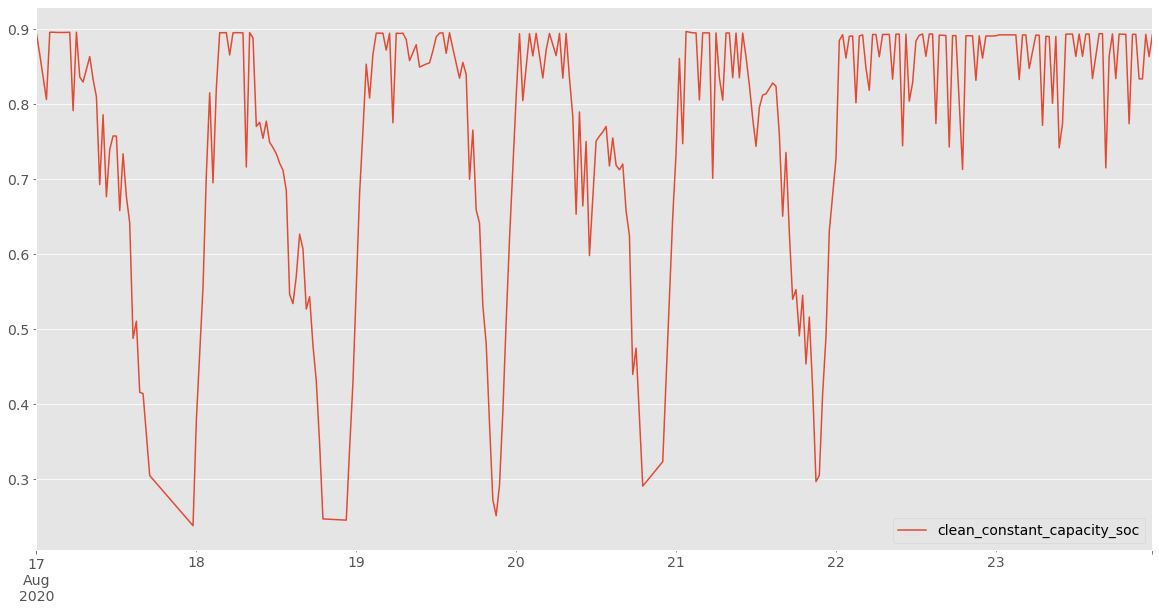

In [54]:
PowerBal_df[['clean_constant_capacity_soc']].plot()

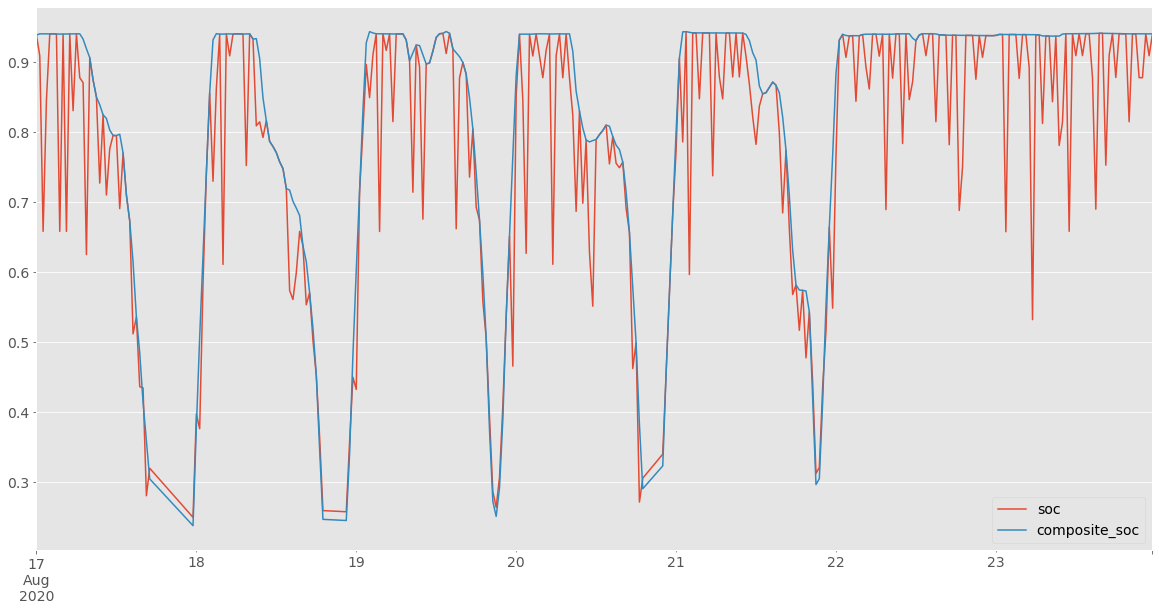

In [55]:
PowerBal_df[['soc','composite_soc']].plot()
#composite is probably not a good idea, want to keep calculation methods constant
#composite soc lower at lower end

In [56]:
missing_data_percent(PowerBal_df)

pv_generation - 0.0%
soc - 0.0%
total_capacity - 0.0%
current_stored_energy - 0.0%
building_draw - 0.0%
post_clean_soc - 0.0%
clean_constant_capacity_soc - 0.0%
composite_soc - 0.0%
deltaP - 0.0%
dBatt - 0.0%
Pbal - 0.0%


In [57]:
w2rtac_df = get_data_section(client, '_rtac', w2st, w2et, uuid_dict, '1T')
w2rtac_df = w2rtac_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
w2rtac_df.head()

pv_generation       soc  total_capacity  \
2020-08-10 00:00:00            0.0  0.939778   165847.966667   
2020-08-10 00:30:00            0.0  0.657776   116097.533333   
2020-08-10 01:00:00            0.0  0.908586   160327.966667   
2020-08-10 01:30:00            0.0  0.939870   165858.500000   
2020-08-10 02:00:00            0.0  0.939896   165855.200000   

                     current_stored_energy  building_draw  
2020-08-10 00:00:00          155860.266667   37398.242839  
2020-08-10 00:30:00          109094.466667   34275.929688  
2020-08-10 01:00:00          150694.866667   32945.394759  
2020-08-10 01:30:00          155885.433333   34676.522135  
2020-08-10 02:00:00          155886.750000   34347.555990

In [58]:
w2PowerBal_df=PowerCols(intp_on_null(w2rtac_df,'total_capacity','current_stored_energy'))

In [59]:
w2PowerBal_df.head()

pv_generation       soc  total_capacity  \
2020-08-10 00:00:00            0.0  0.939778   165847.966667   
2020-08-10 00:30:00            0.0  0.657776   116097.533333   
2020-08-10 01:00:00            0.0  0.908586   160327.966667   
2020-08-10 01:30:00            0.0  0.939870   165858.500000   
2020-08-10 02:00:00            0.0  0.939896   165855.200000   

                     current_stored_energy  building_draw  post_clean_soc  \
2020-08-10 00:00:00          155860.266667   37398.242839        0.939778   
2020-08-10 00:30:00          109094.466667   34275.929688        0.939679   
2020-08-10 01:00:00          150694.866667   32945.394759        0.939916   
2020-08-10 01:30:00          155885.433333   34676.522135        0.939870   
2020-08-10 02:00:00          155886.750000   34347.555990        0.939897   

                     clean_constant_capacity_soc  composite_soc        deltaP  \
2020-08-10 00:00:00                     0.895749       0.939778 -37398.242839   
2020-08-10 00:30:00                     0.626980       0.939679 -34275.929688   
2020-08-10 01:00:00                     0.866062       0.939916 -32945.394759   
2020-08-10 01:30:00                     0.895893       0.939870 -34676.522135   
2020-08-10 02:00:00                     0.895901       0.939897 -34347.555990   

                            dBatt          Pbal  
2020-08-10 00:00:00           NaN           NaN  
2020-08-10 00:30:00 -46765.800000 -81041.729688  
2020-08-10 01:00:00  41600.400000   8655.005241  
2020-08-10 01:30:00   5190.566667 -29485.955469  
2020-08-10 02:00:00      1.316667 -34346.239323

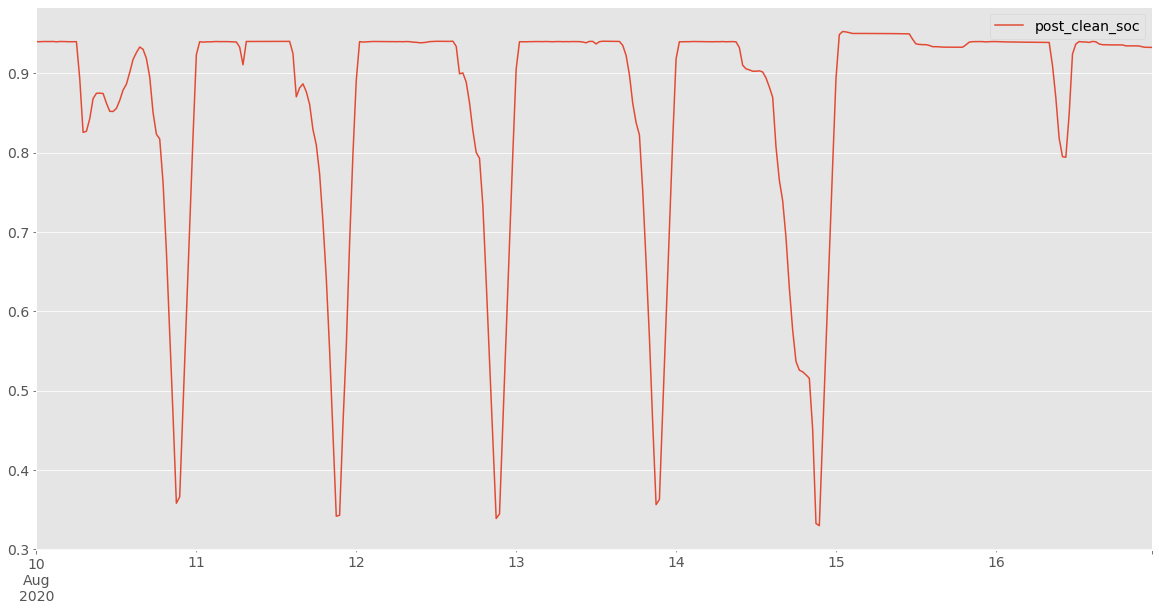

In [60]:
w2PowerBal_df[['post_clean_soc']].plot()

#### Comparing SOC to site scale electrical features on a daily basis

#### Daily plotting of Building Draw, PV, and SOC percents

In [61]:
#how to save separate plots to dictionary or List to be plotted later maybe this: https://stackoverflow.com/questions/54619197/store-multiple-matplotlib-figures-in-a-dictionary-and-use-keys-to-display-them
#I can't dang figure out how to keep formatting and plot side by side 
def NetPower(df):
    plotList=[]
    plotDict={}
    df=df.reset_index()
    df['date']=df['index'].dt.date
    df['time']=df['index'].dt.time
    days=df['date'].unique()
    groups=df.groupby('date')
    for i in days: 
        gdf=groups.get_group(i).copy()
        gdf=gdf.set_index('index')
        gdf['percent_pv']=gdf['pv_generation']/gdf['pv_generation'].max()
        gdf['percent_building_draw']=gdf['building_draw']/gdf['building_draw'].max()
        #display(gdf.head())
        plt.plot(gdf['post_clean_soc'], label='soc')
        plt.plot(gdf['percent_pv'], label='PV% of days max: {}'.format(math.trunc(gdf['pv_generation'].max())))
        plt.plot(gdf['percent_building_draw'], label='Power Draw % of days max: {}'.format(math.trunc(gdf['building_draw'].max())))
        plt.title('Net Power on {}'.format(i))
        t_fmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_formatter(t_fmt)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    

In [62]:

def PVvsSOC(df):
    plotList=[]
    plotDict={}
    df=df.reset_index()
    df['date']=df['index'].dt.date
    df['time']=df['index'].dt.time
    days=df['date'].unique()
    groups=df.groupby('date')

    # fig = plt.figure()
    # ax1 = fig.add_subplot(1,2,1)


    for i in days: 
        gdf=groups.get_group(i).copy()
        gdf=gdf.set_index('index')
        gdf['percent_pv']=gdf['pv_generation']/gdf['pv_generation'].max()
        #gdf['percent_building_draw']=gdf['building_draw']/gdf['building_draw'].max()
        #display(gdf.head())
        plt.plot(gdf['post_clean_soc'], label='soc')
        plt.plot(gdf['percent_pv'], label='PV% of days max: {}'.format(math.trunc(gdf['pv_generation'].max())))
        #plt.plot(gdf['percent_building_draw'], label='Power Draw % of days max: {}'.format(math.trunc(gdf['building_draw'].max())))
        plt.title('PV vs. SOC on {}'.format(i))
        t_fmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_formatter(t_fmt)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    

In [63]:
# graphing SOC and PV
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelpad'] = 10
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 14})

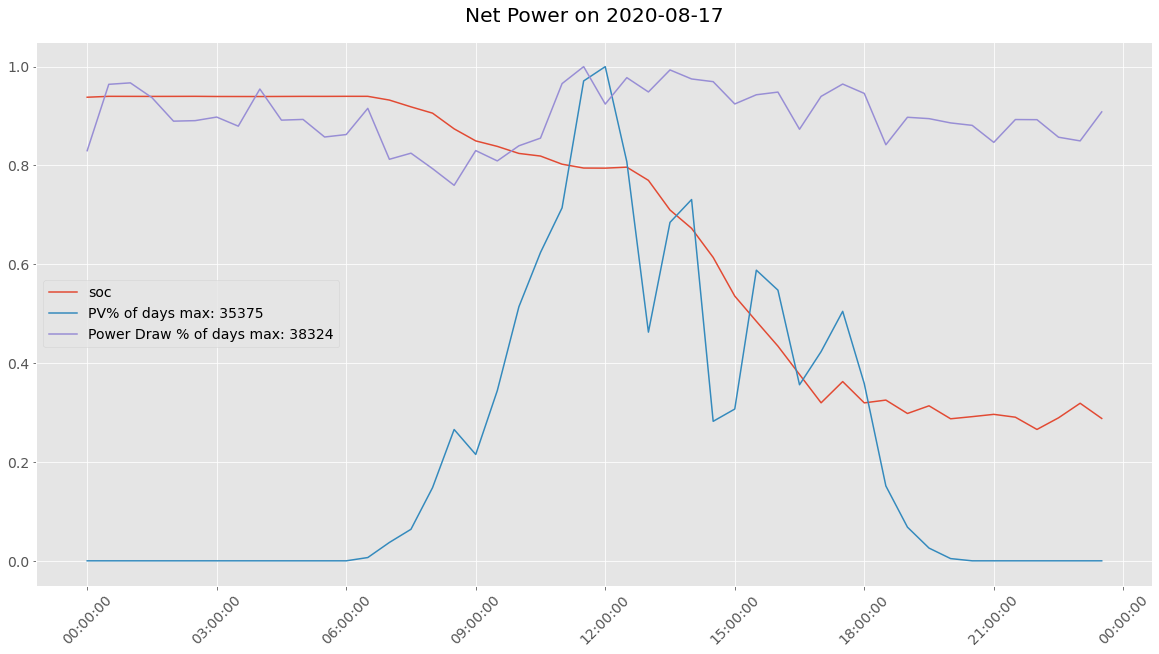

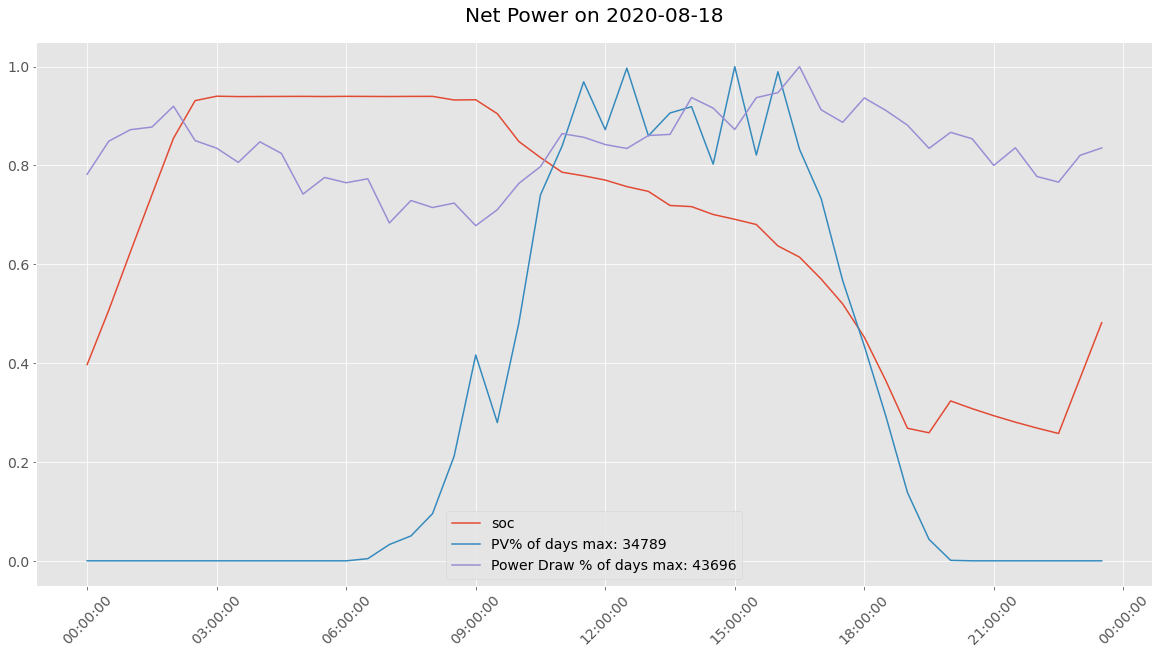

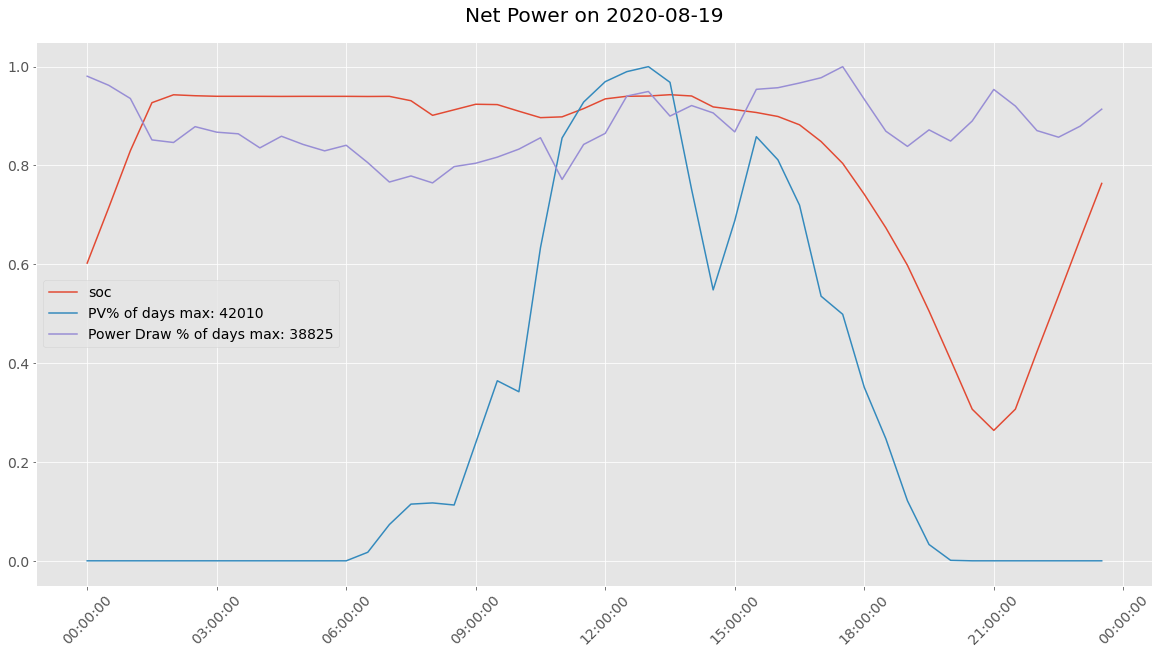

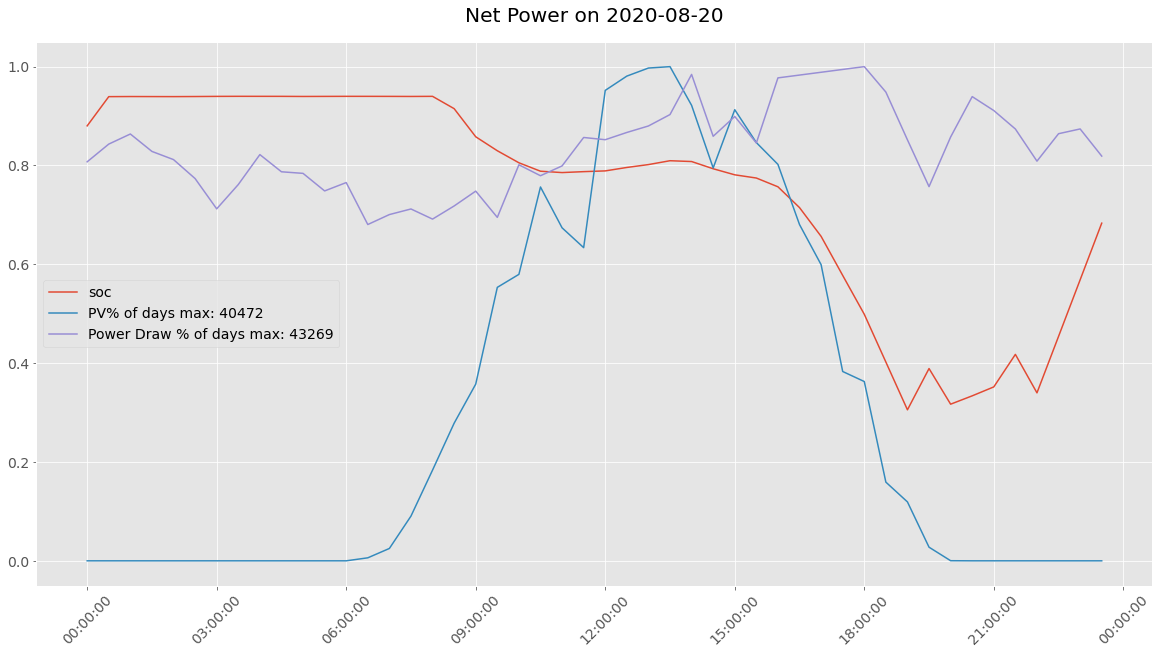

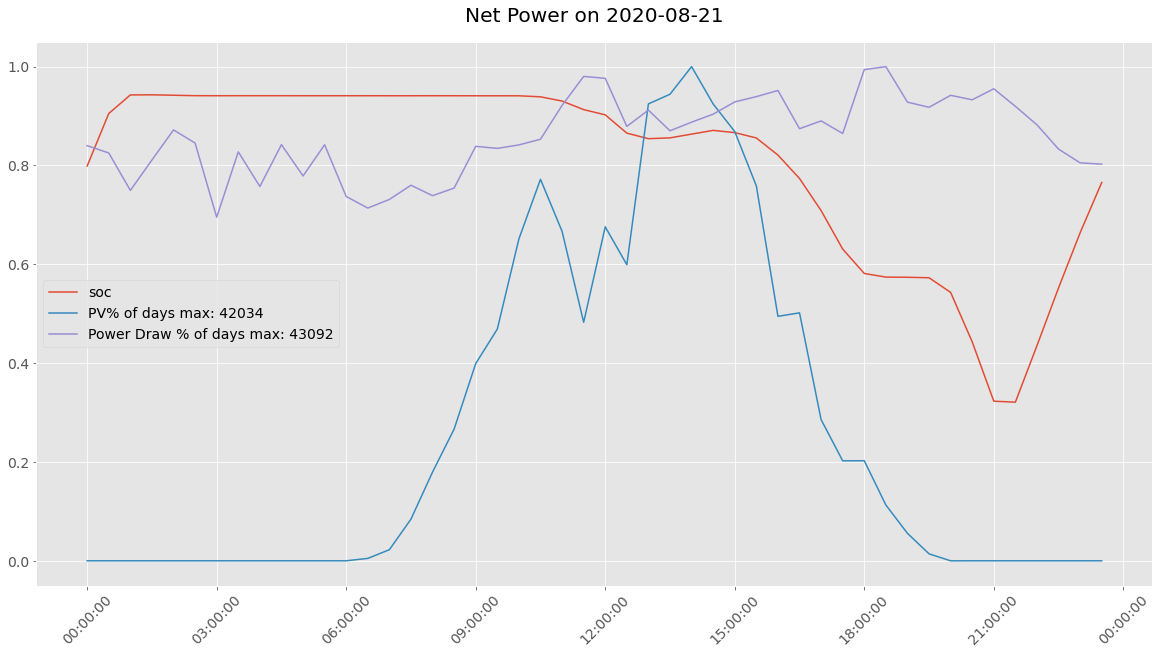

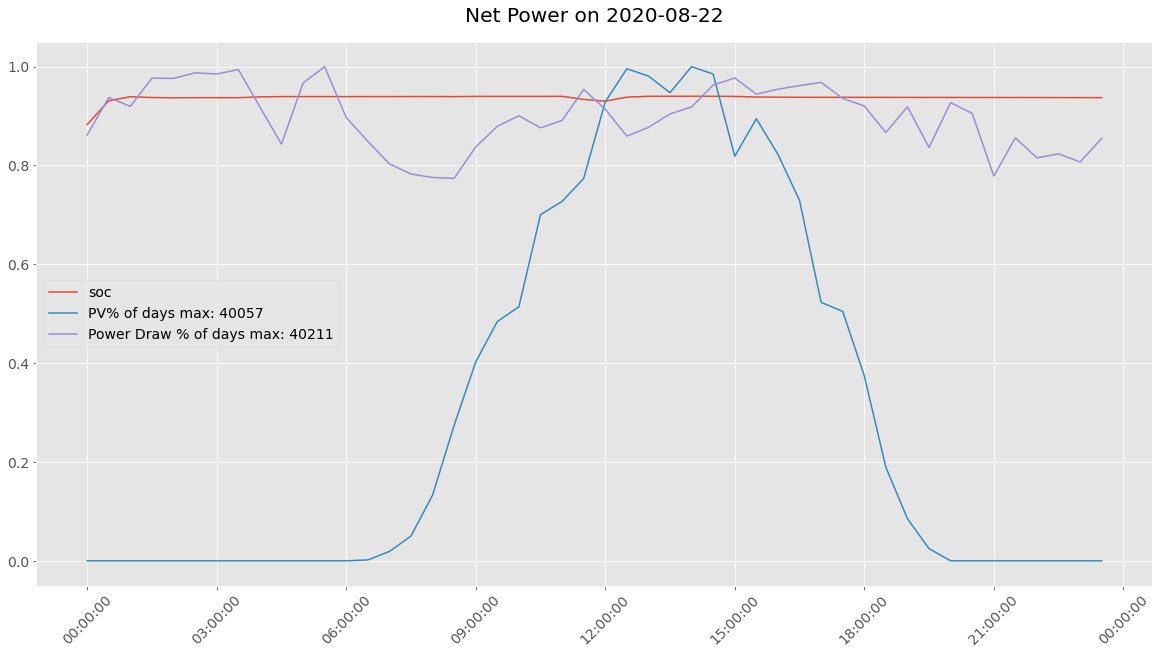

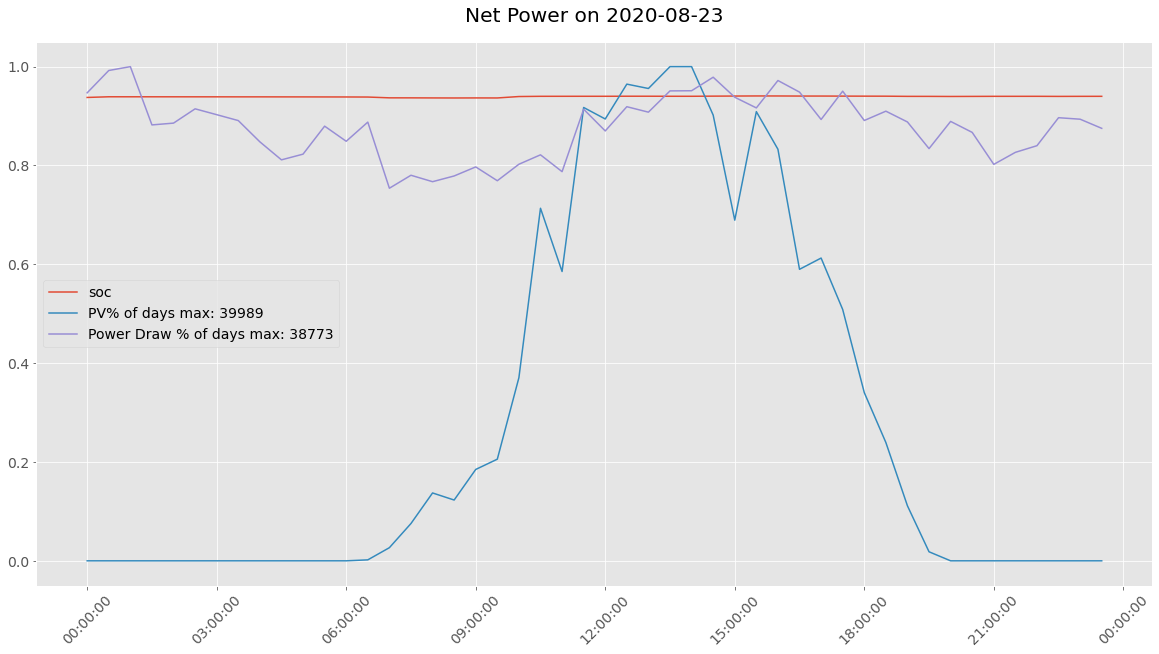

In [64]:
NetPower(PowerBal_df)

In [65]:
print(PowerBal_df['post_clean_soc']['2020-08-17 20:30:00'])
print(PowerBal_df['post_clean_soc']['2020-08-17 21:00:00'])
print(PowerBal_df['post_clean_soc']['2020-08-17 21:30:00'])

0.2917506985431515
0.29639081274278056
0.2906111940496333


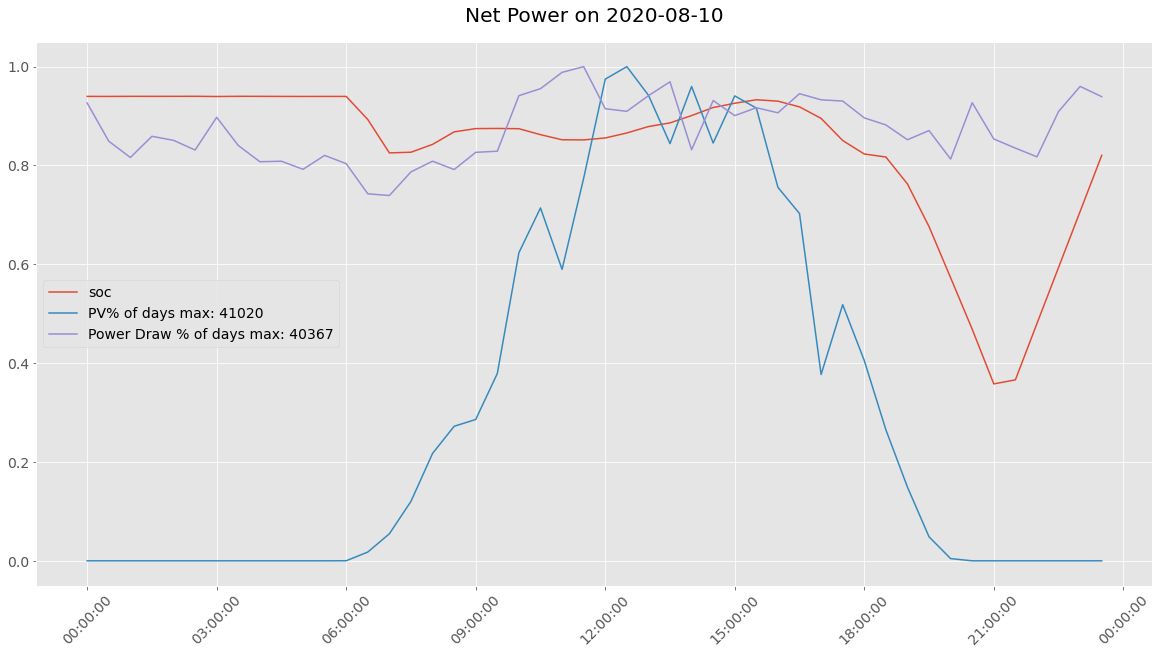

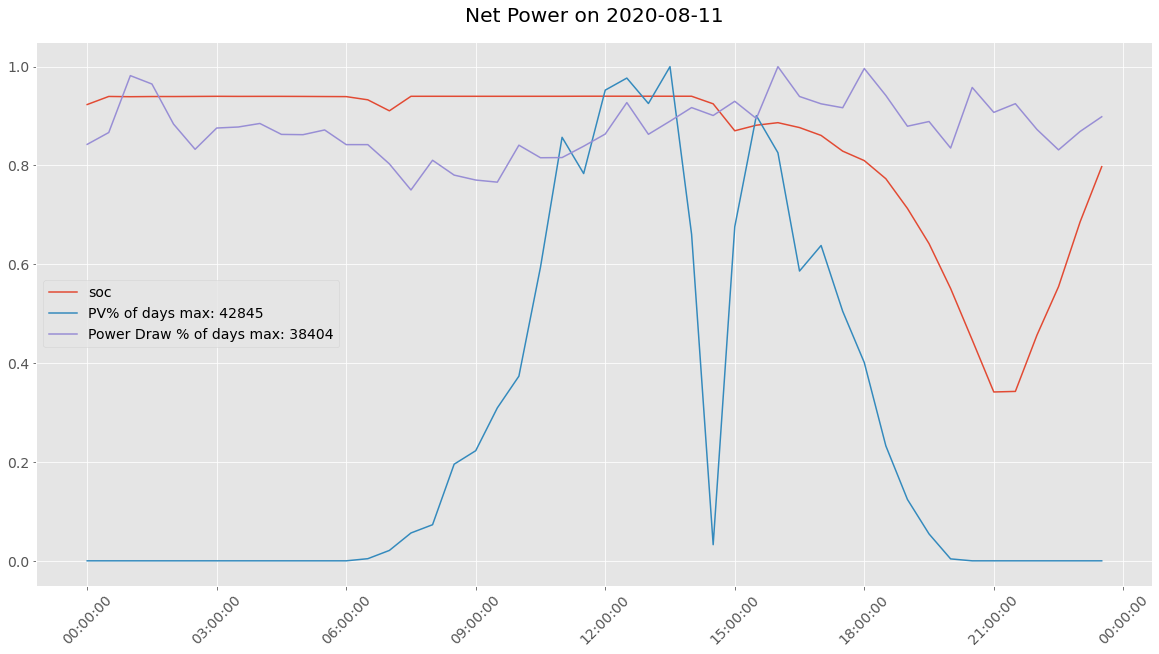

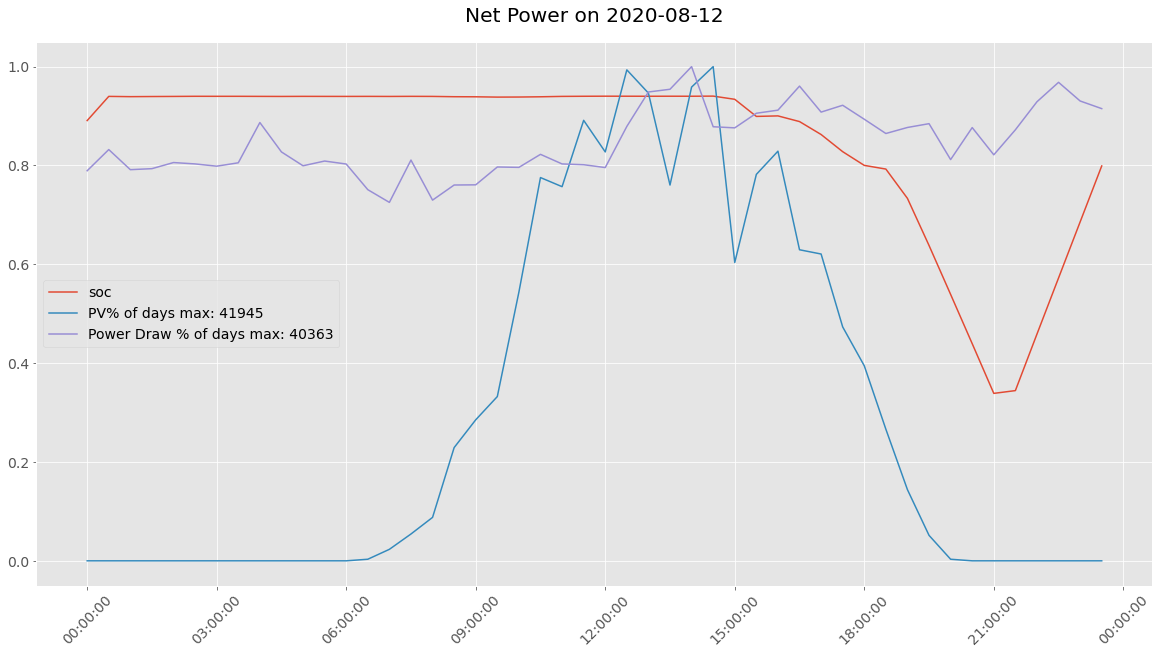

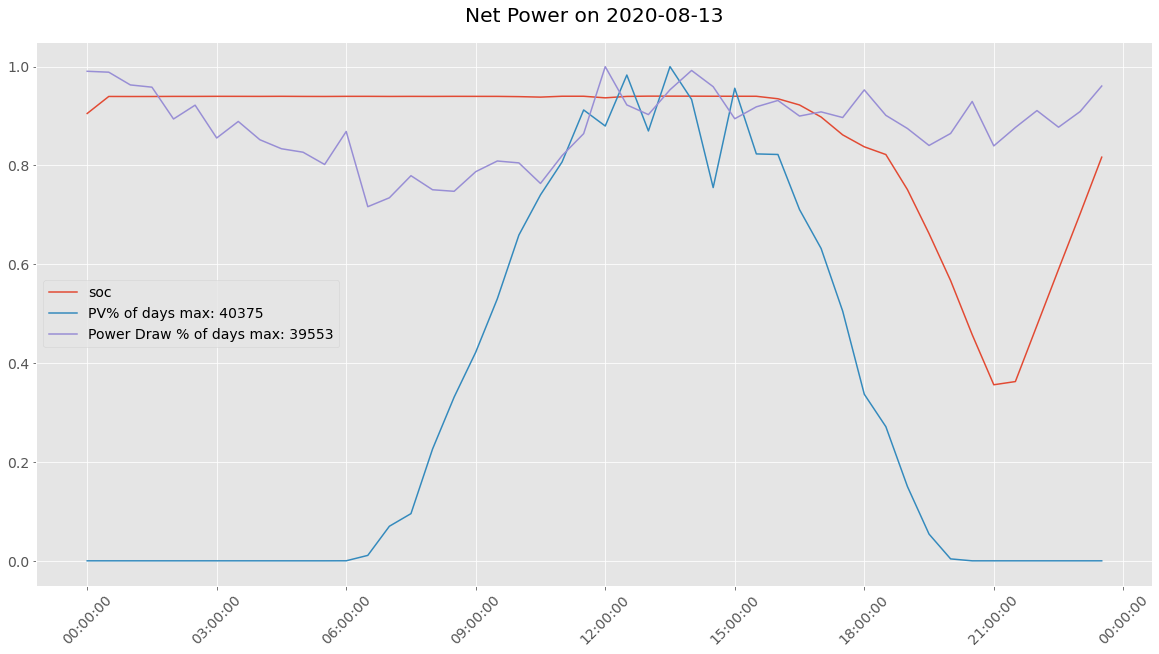

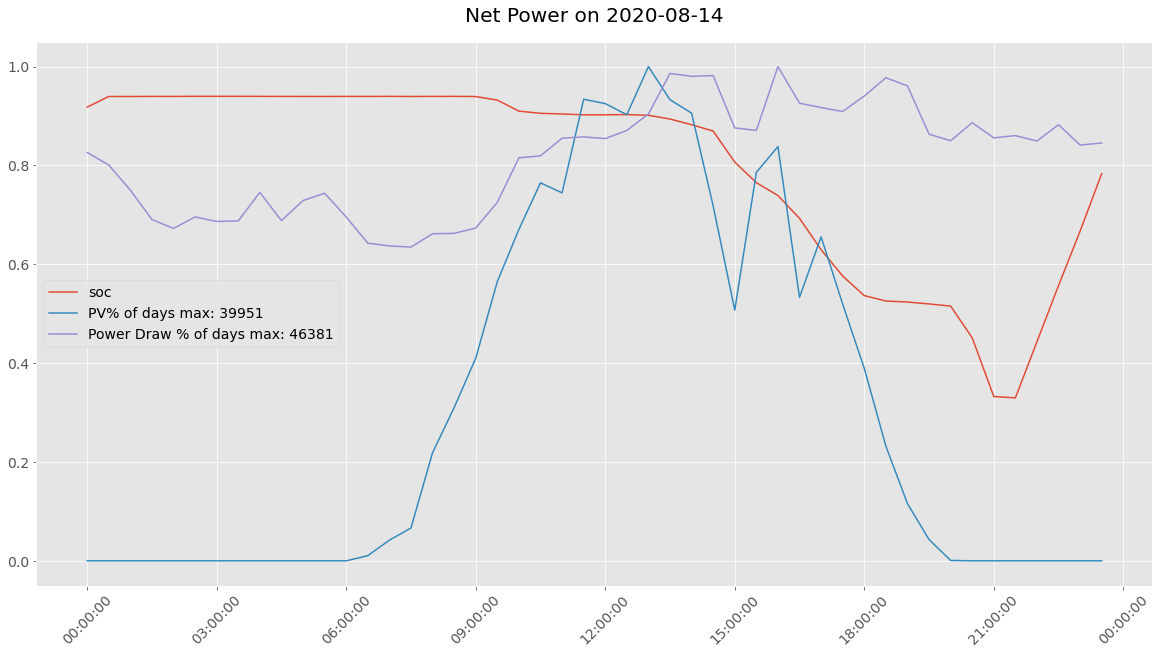

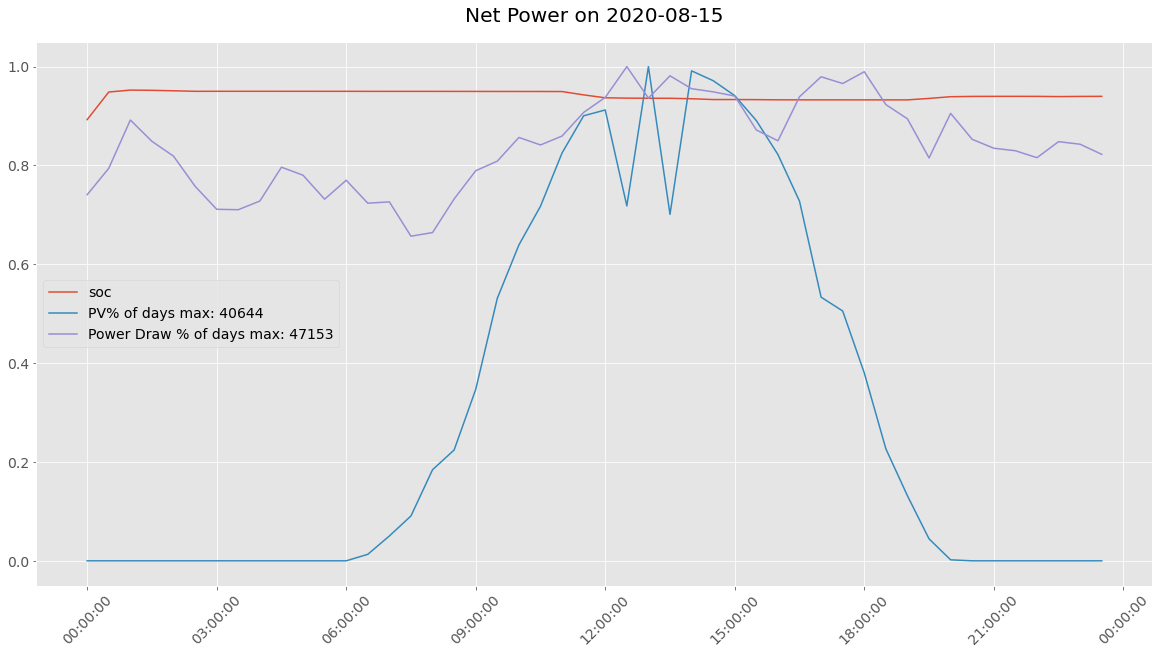

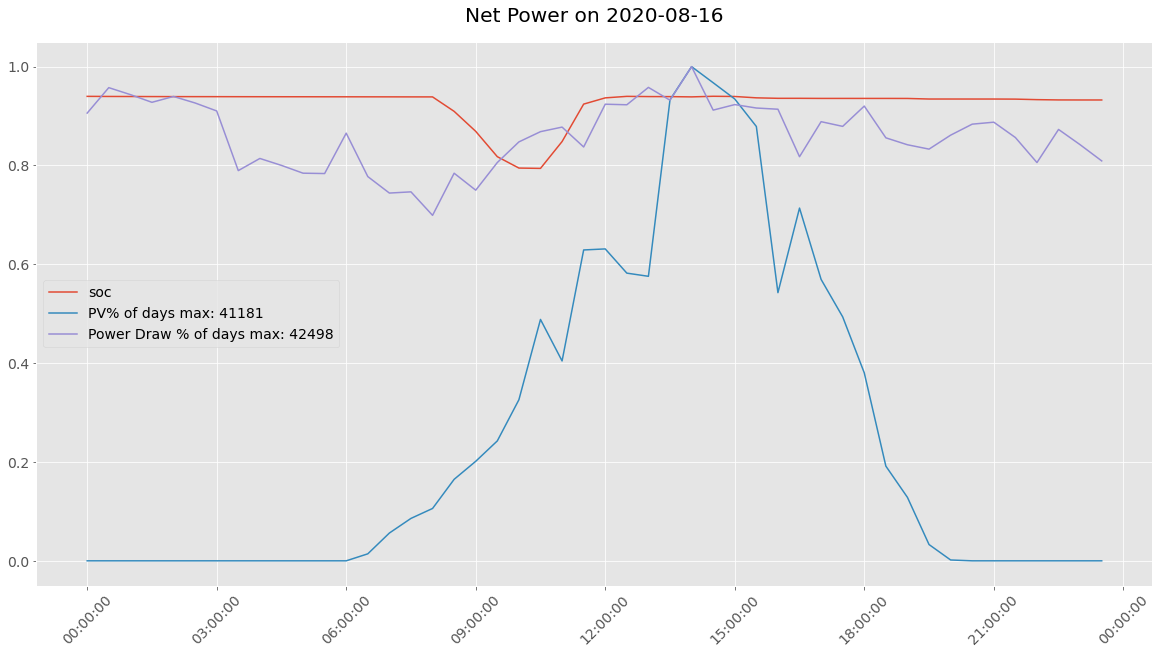

In [66]:
NetPower(w2PowerBal_df)

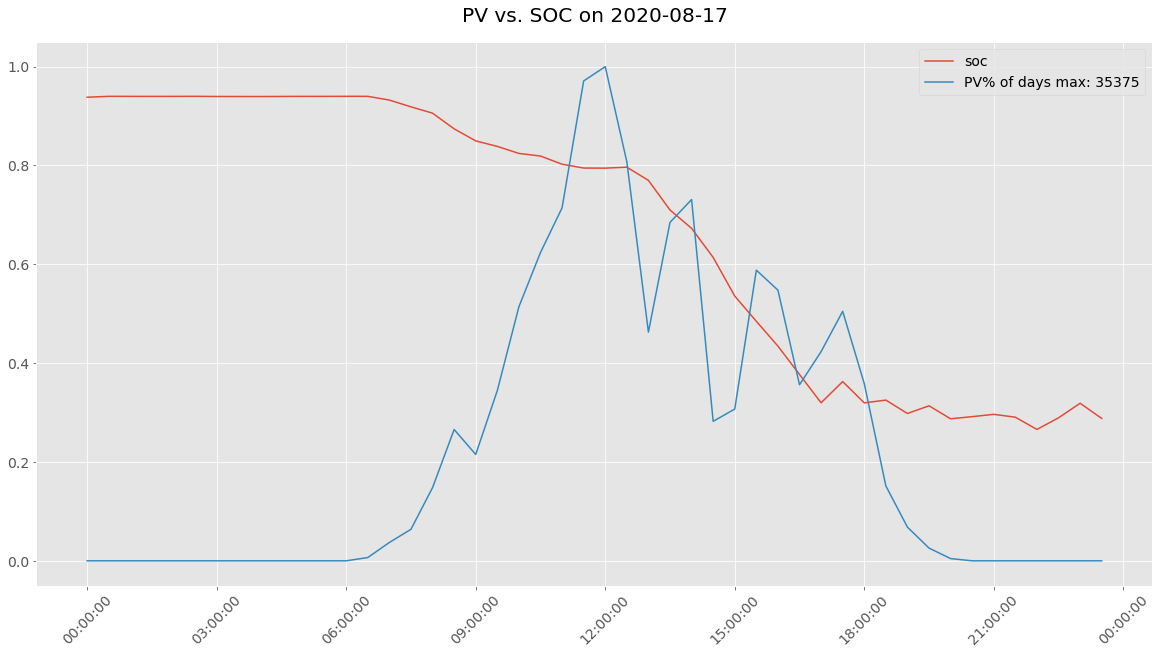

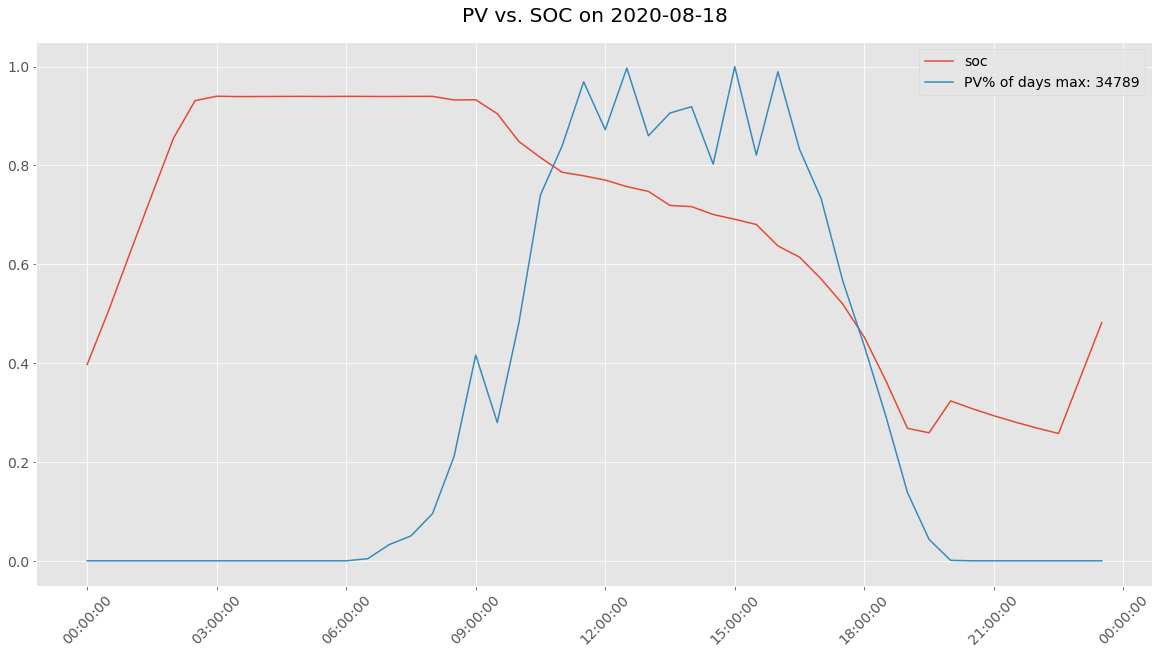

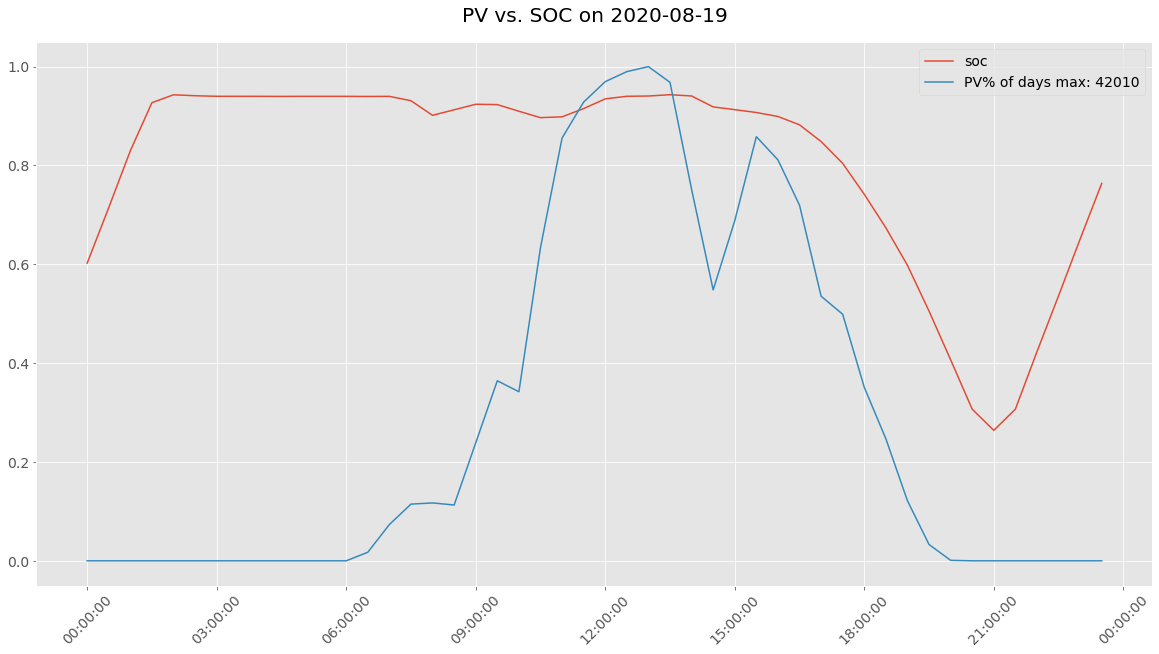

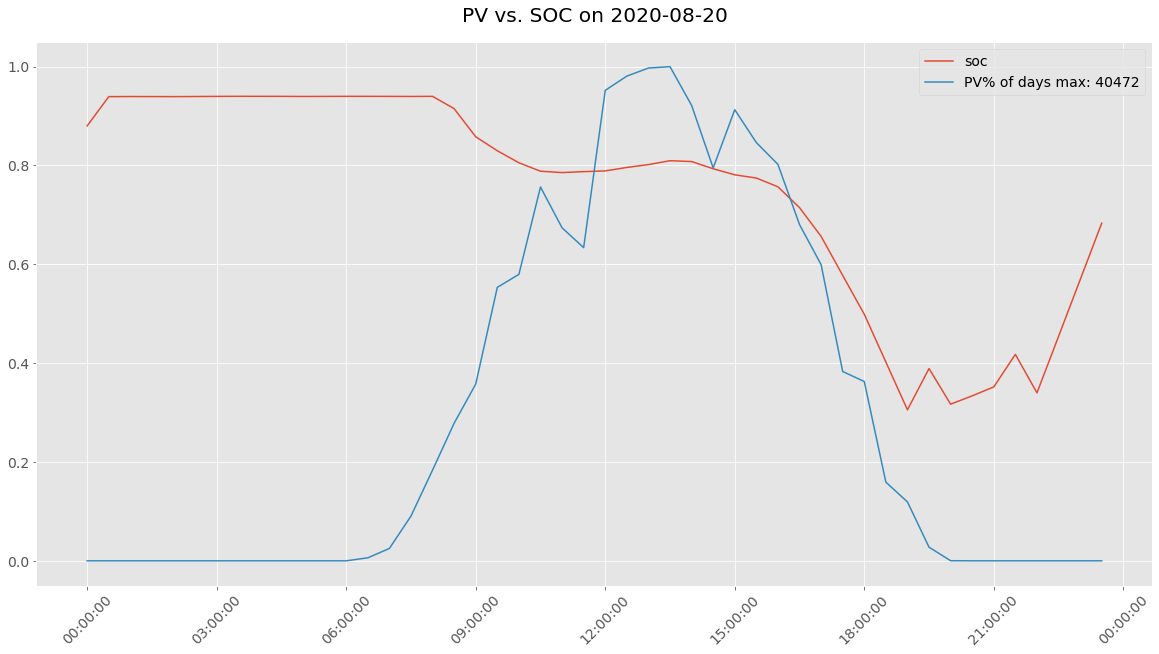

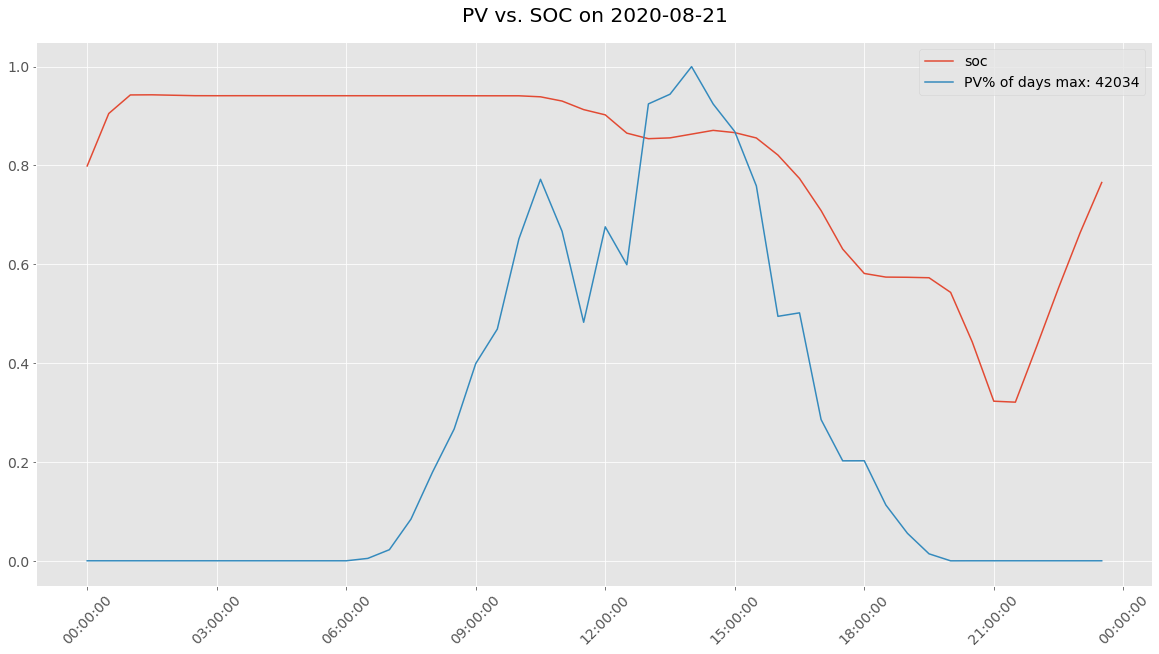

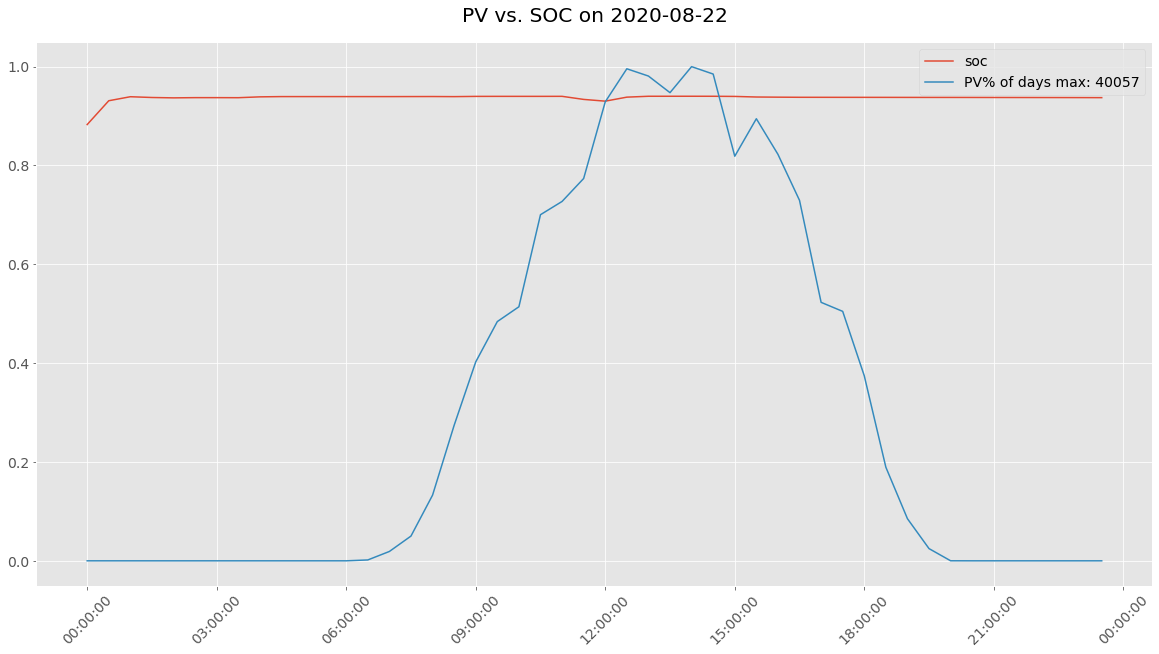

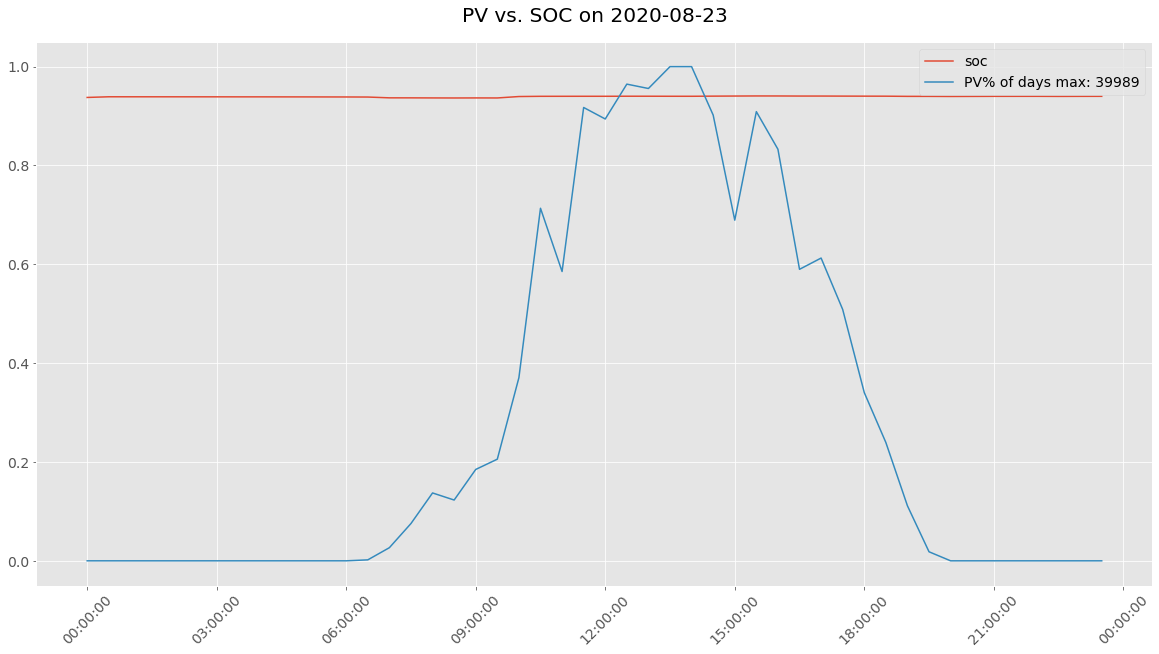

In [67]:
PVvsSOC(PowerBal_df)

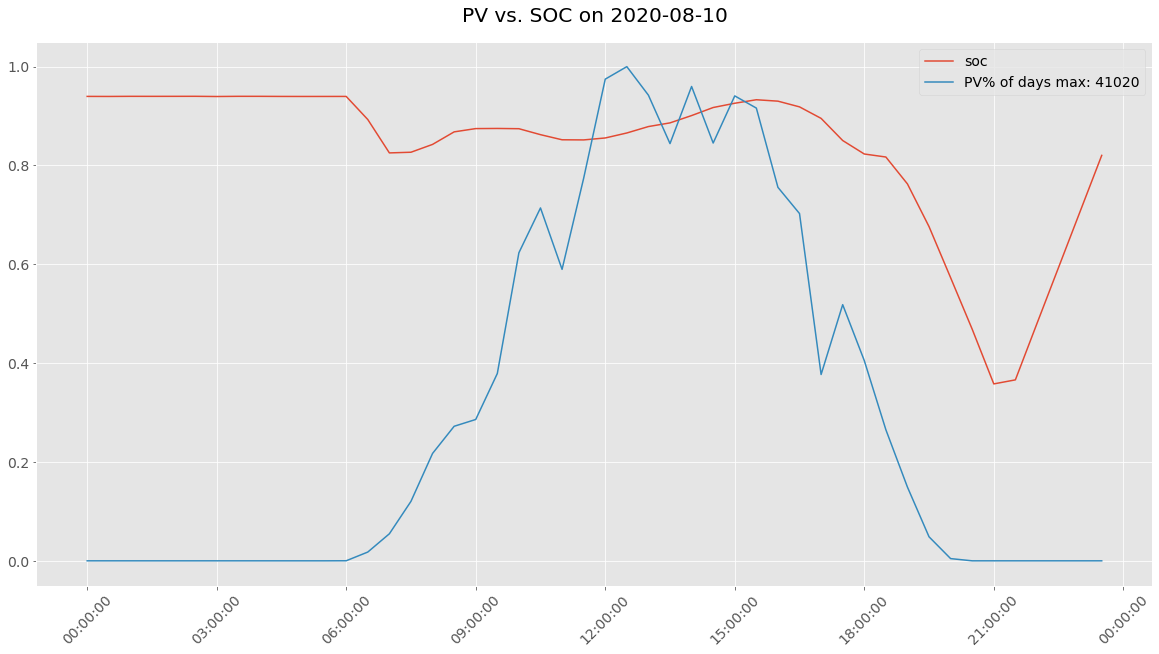

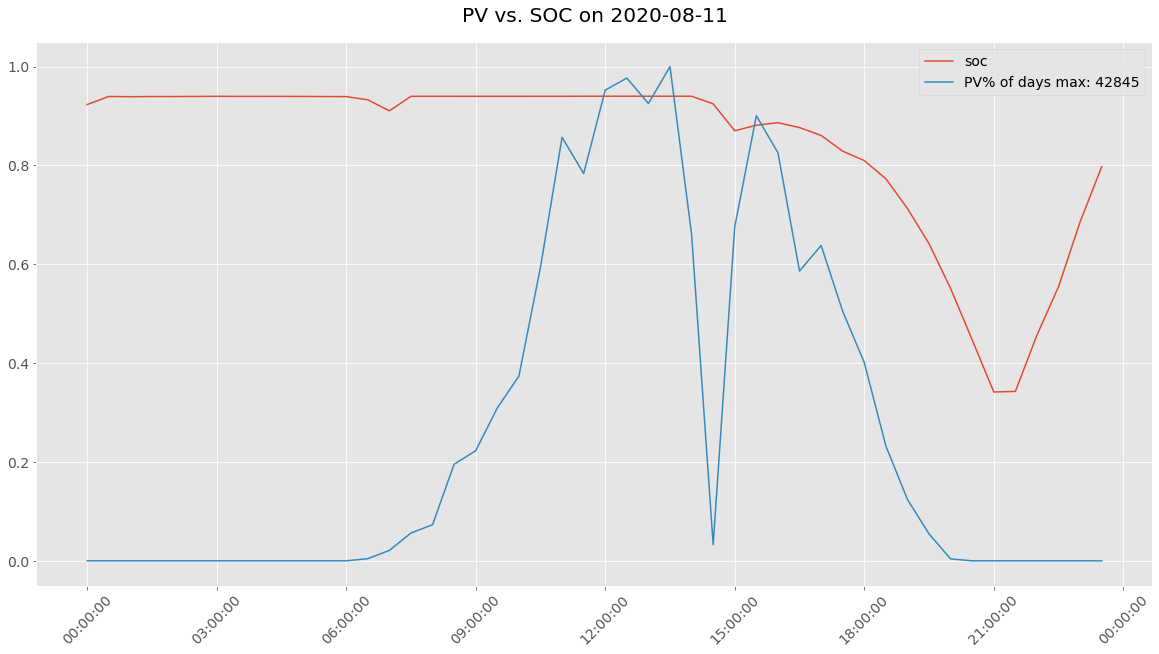

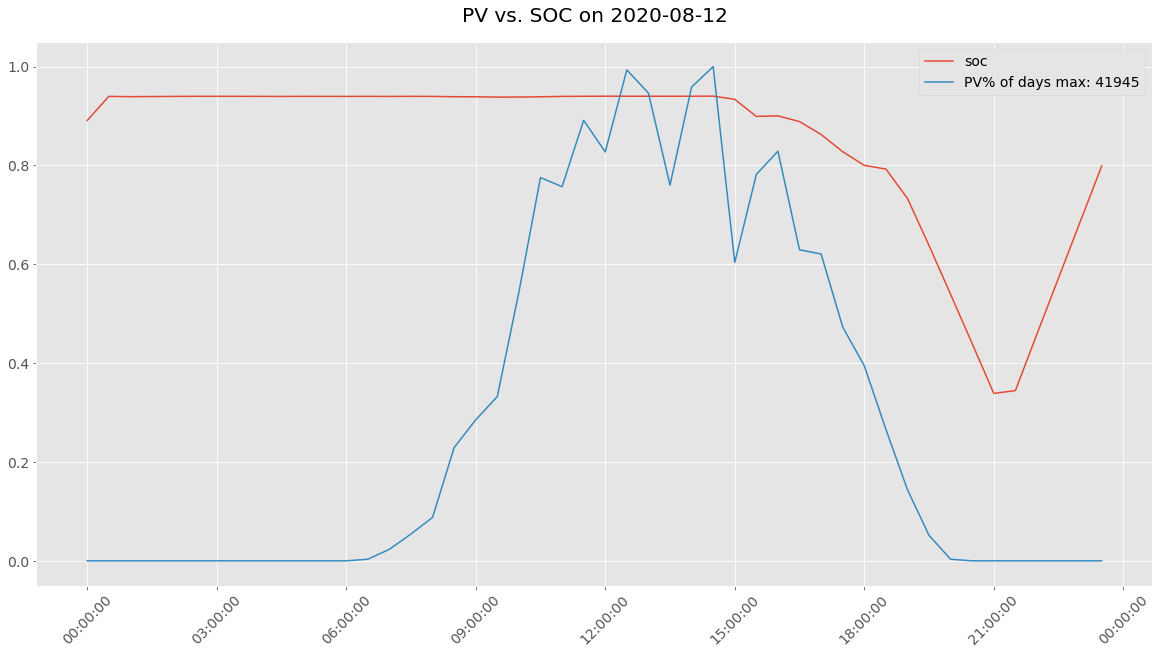

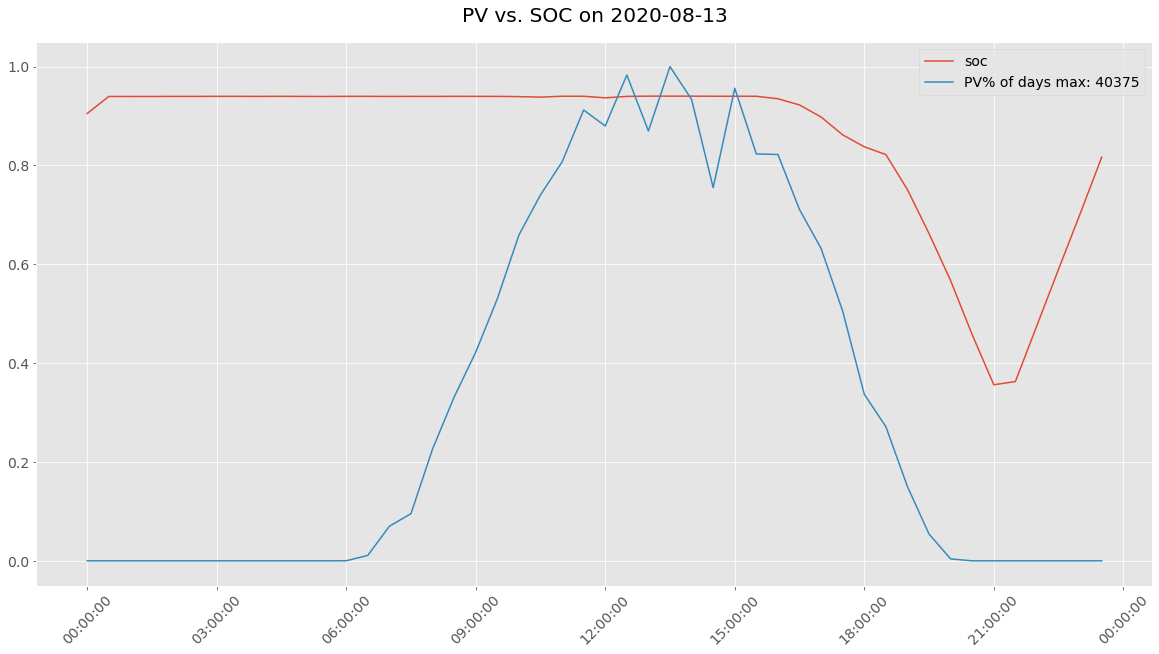

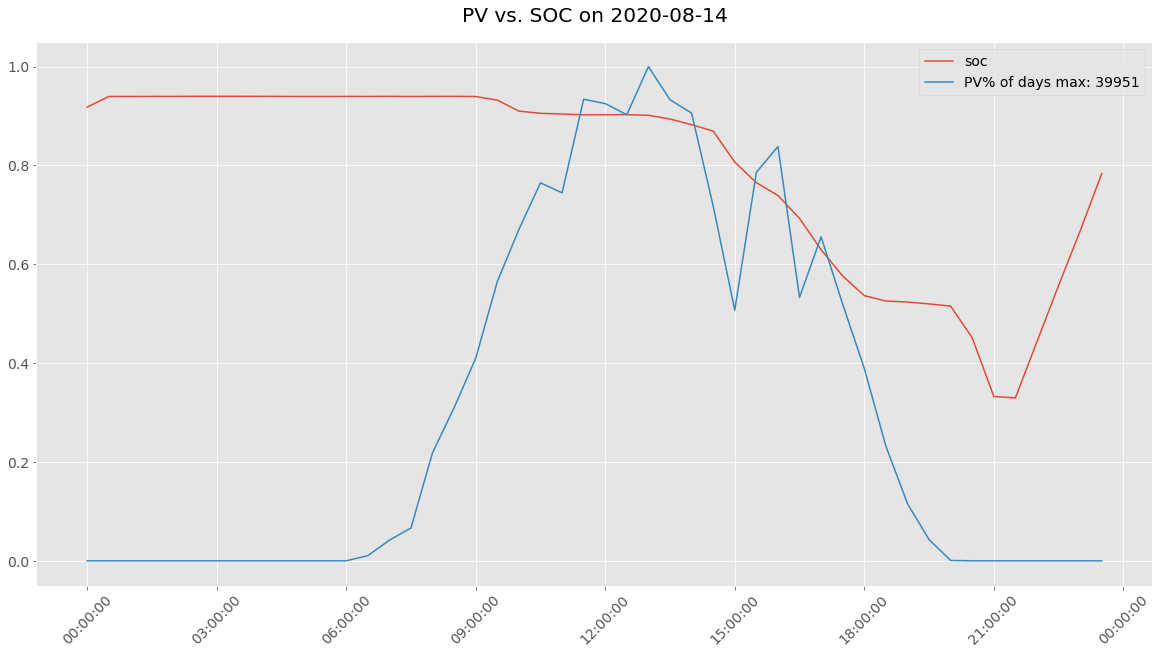

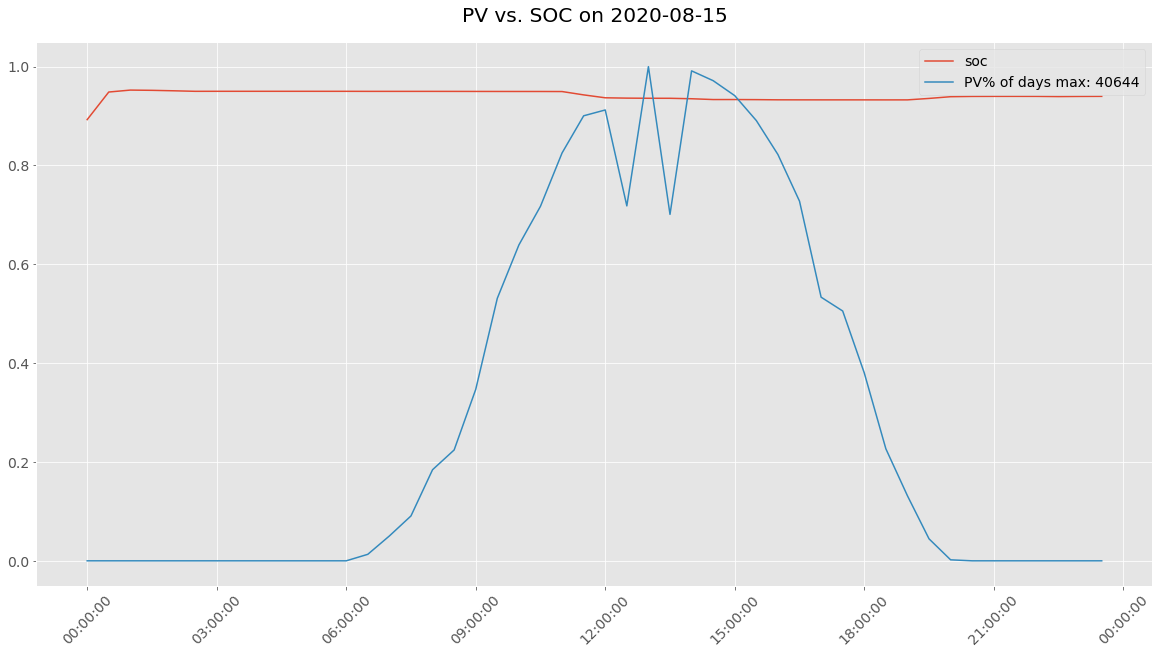

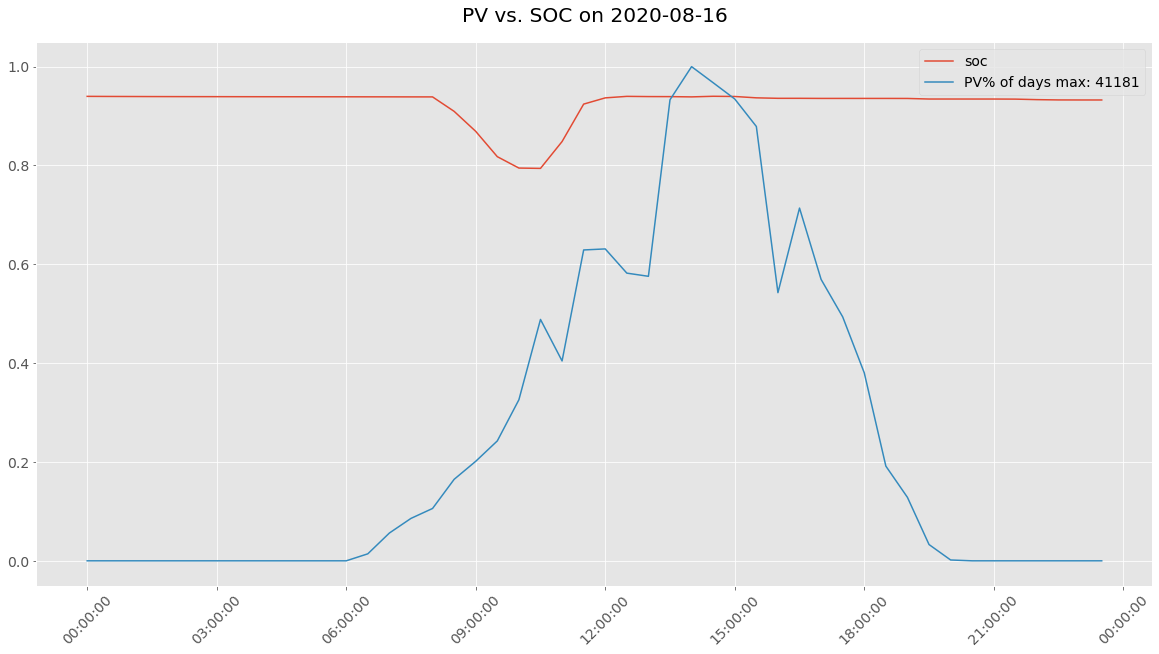

In [68]:
PVvsSOC(w2PowerBal_df)

#### Energy Use/Production on Building Scale

In [69]:
#how to save separate plots to dictionary or List to be plotted later maybe this: https://stackoverflow.com/questions/54619197/store-multiple-matplotlib-figures-in-a-dictionary-and-use-keys-to-display-them
#I can't dang figure out how to keep formatting and plot side by side 
def EnergyPlots(df):

    df=df.reset_index()
    df['date']=df['index'].dt.date
    df['time']=df['index'].dt.time
    days=df['date'].unique()
    groups=df.groupby('date')
    
    for i in days: 
        gdf=groups.get_group(i).copy()
        gdf=gdf.set_index('index')
        gdf['PV_Energy']=leftInt(gdf,['pv_generation'])
        gdf['Energy_Use']=leftInt(gdf,['building_draw'])
        gdf['Battery_Expended']=leftInt(gdf,['dBatt']) #could do this by subtracting current from previous current value using shift, is it better that it's consistent or should I do that?
        #display(gdf.head())
        plt.plot(gdf['Battery_Expended'],label='Energy Expended By Battery')
        #plt.plot(gdf['current_stored_energy'], label='Battery Energy Stored')
        plt.plot(gdf['PV_Energy'], label='PV')
        plt.plot(gdf['Energy_Use'], label='Energy Use')
        plt.title('Daily Energy Use/Production on {}'.format(i))
        print(gdf['PV_Energy'].tail(1)-gdf['Energy_Use'].tail(1))
        t_fmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_formatter(t_fmt)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    

In [70]:
def leftInt(df,col):
    df['temp']=0.5*df[col]     #half an hour is interval (energy in kWh)
    return df['temp'].cumsum()

In [71]:
PowerBal_df.head(2)

pv_generation       soc  total_capacity  \
2020-08-17 00:00:00            0.0  0.938097   165727.633333   
2020-08-17 00:30:00            0.0  0.908577   160202.800000   

                     current_stored_energy  building_draw  post_clean_soc  \
2020-08-17 00:00:00          155468.566667   31805.438281        0.938097   
2020-08-17 00:30:00          150575.833333   36953.611589        0.939908   

                     clean_constant_capacity_soc  composite_soc        deltaP  \
2020-08-17 00:00:00                     0.893498       0.938097 -31805.438281   
2020-08-17 00:30:00                     0.865378       0.939908 -36953.611589   

                           dBatt          Pbal  
2020-08-17 00:00:00          NaN           NaN  
2020-08-17 00:30:00 -4892.733333 -41846.344922

index
2020-08-17 23:30:00   -627653.865335
dtype: float64


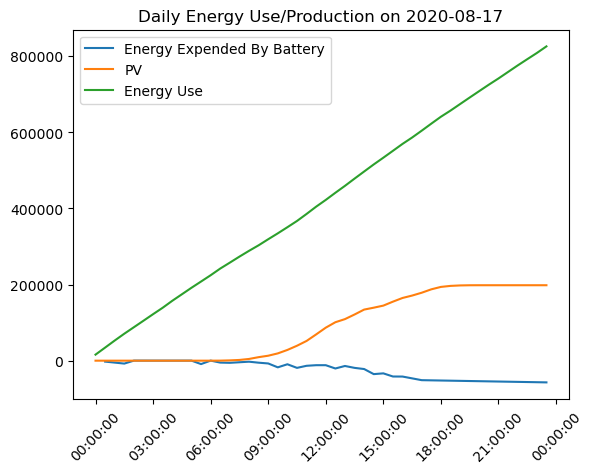

index
2020-08-18 23:30:00   -606727.515662
dtype: float64


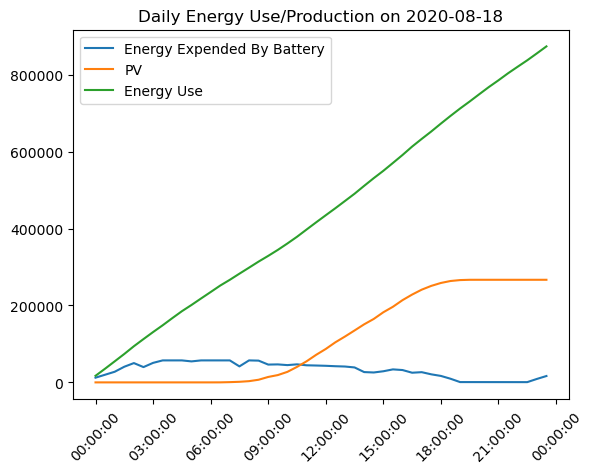

index
2020-08-19 23:30:00   -525240.826174
dtype: float64


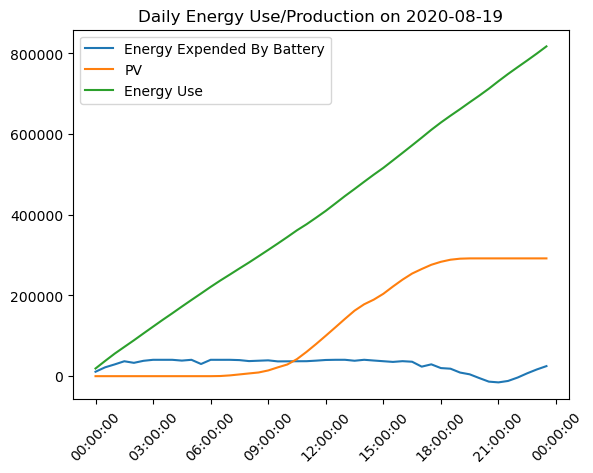

index
2020-08-20 23:30:00   -568999.129484
dtype: float64


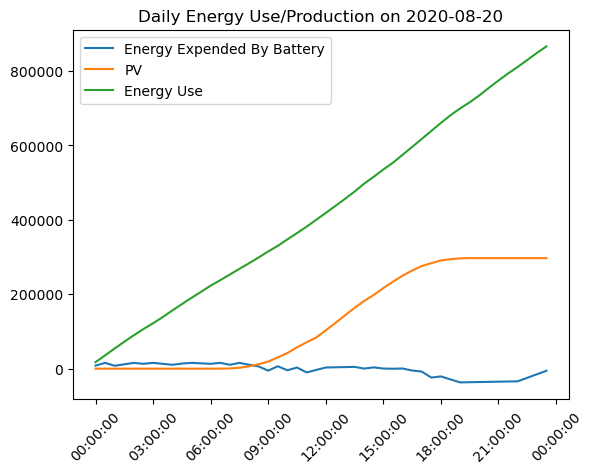

index
2020-08-21 23:30:00   -623290.302007
dtype: float64


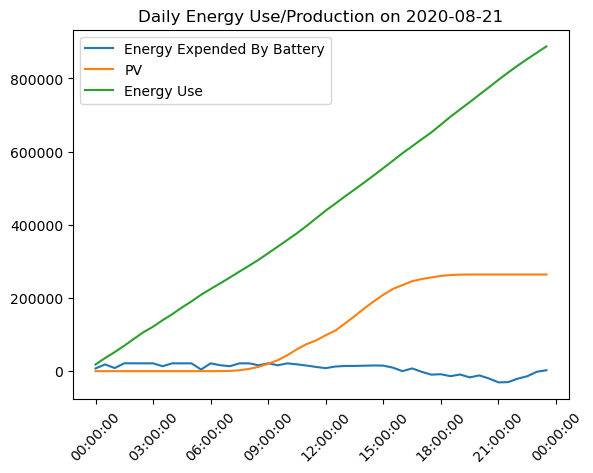

index
2020-08-22 23:30:00   -567928.353098
dtype: float64


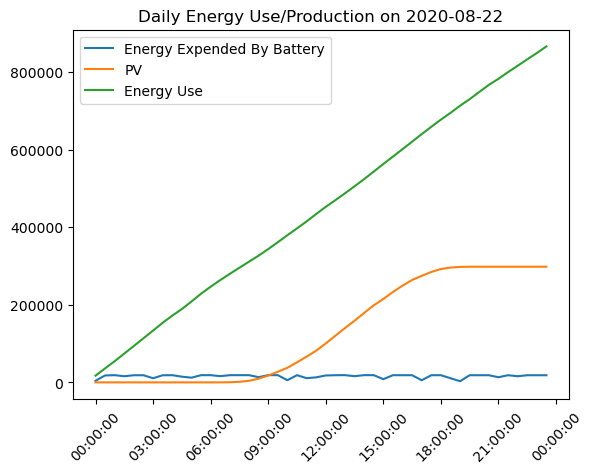

index
2020-08-23 23:30:00   -537961.052599
dtype: float64


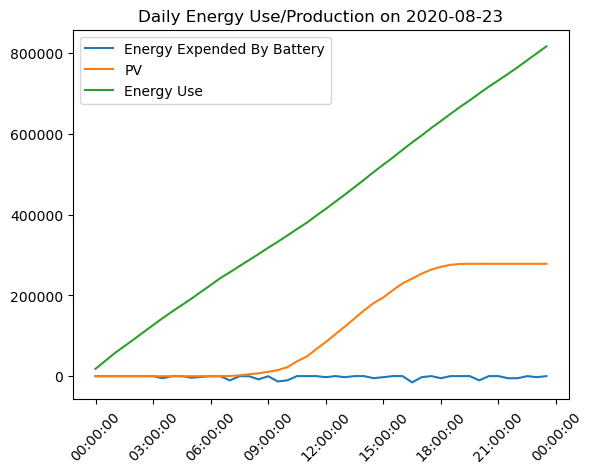

In [72]:
plt.rcParams.update(plt.rcParamsDefault)
EnergyPlots(PowerBal_df)

index
2020-08-10 23:30:00   -544211.246043
dtype: float64


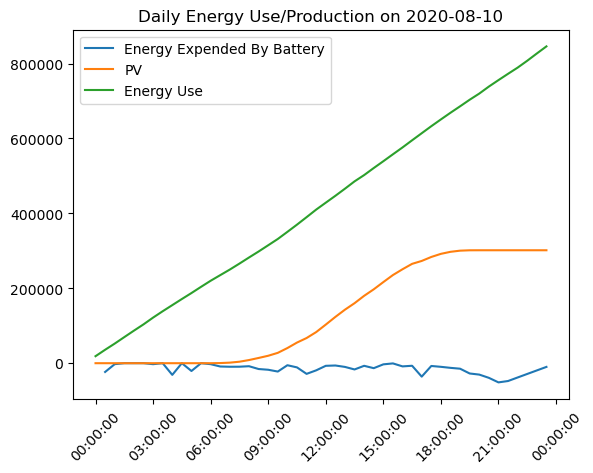

index
2020-08-11 23:30:00   -529372.444785
dtype: float64


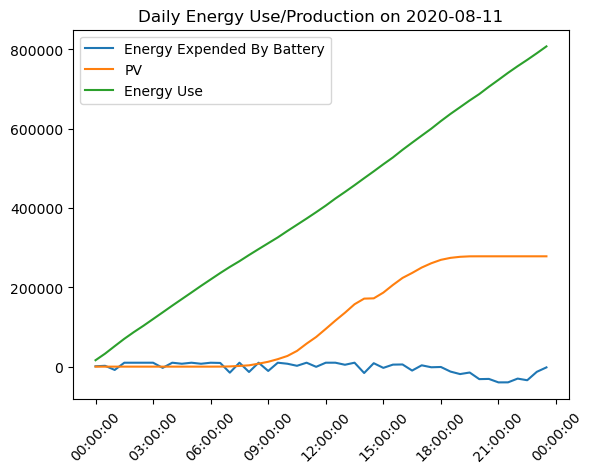

index
2020-08-12 23:30:00   -521942.60933
dtype: float64


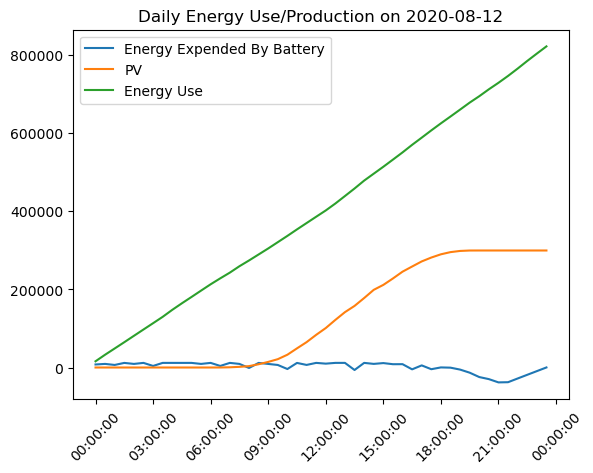

index
2020-08-13 23:30:00   -520677.35284
dtype: float64


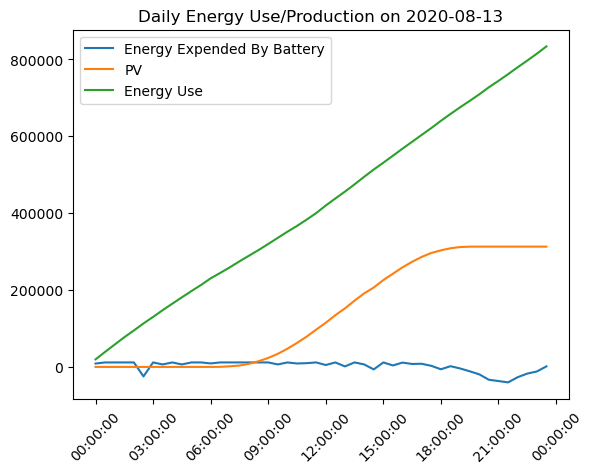

index
2020-08-14 23:30:00   -612057.966784
dtype: float64


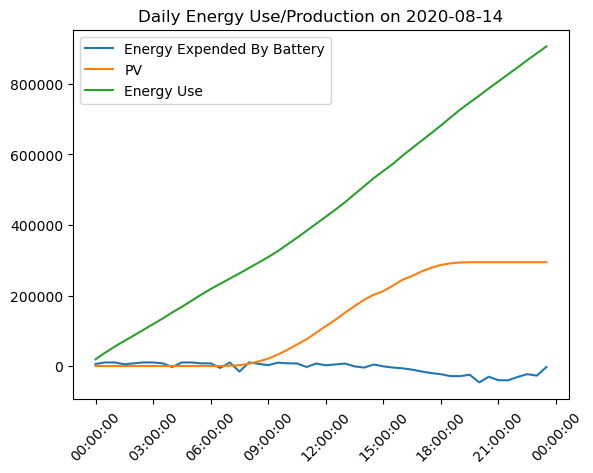

index
2020-08-15 23:30:00   -645516.021776
dtype: float64


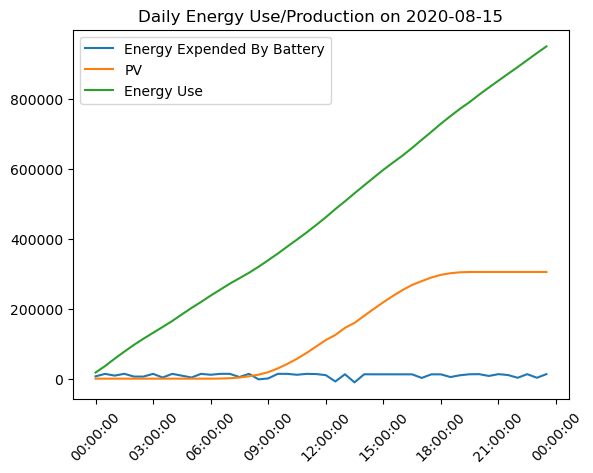

index
2020-08-16 23:30:00   -625777.540855
dtype: float64


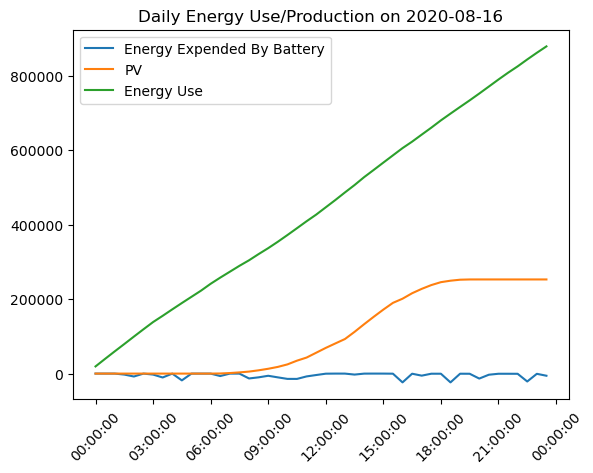

In [73]:
EnergyPlots(w2PowerBal_df)

#### Time of Discharge

In [74]:
#Need a way to look through noise, easier to look at plot
def TofDischarge(df):  
    ToD=[]
    df=df.reset_index()
    df['date']=df['index'].dt.date
    df['time']=df['index'].dt.time
    days=df['date'].unique()
    groups=df.groupby('date')
    for i in days: 
        gdf=groups.get_group(i).copy()
        gdf=gdf.set_index('index')
        gdf=gdf.tail(45)  #omitting the first few entries because the battery recharges at night
        for j in gdf.index:
            if gdf['post_clean_soc'][j] <= .90:
                ToD.append(j)
                break
    return ToD
            
#if increase to original level within a tolerance, continue looking.
#Might be easier to find on plot since the noise and discharge pattern is hard to predict


In [75]:
TofDischarge(PowerBal_df)
#Should I compare this to Outdoor temperature 

[Timestamp('2020-08-17 08:30:00'),
 Timestamp('2020-08-18 01:30:00'),
 Timestamp('2020-08-19 10:30:00'),
 Timestamp('2020-08-20 09:00:00'),
 Timestamp('2020-08-21 12:30:00')]

In [76]:
TofDischarge(w2PowerBal_df)

[Timestamp('2020-08-10 06:30:00'),
 Timestamp('2020-08-11 15:00:00'),
 Timestamp('2020-08-12 15:30:00'),
 Timestamp('2020-08-13 17:00:00'),
 Timestamp('2020-08-14 13:30:00'),
 Timestamp('2020-08-16 09:00:00')]

In [77]:
#       important things: total building load, pv generation, (building_power), battery total stored vs current stored,
#       show that battery worked well, (how battery reacted to load)
#   Last Thursday, battery didn't respond
# Outdoor temperature, how did systems resond?

#### Islanding Event (3-10pm) the week of the 17th

In [78]:
def dfDays(df):
    df=df.reset_index()
    df['date']=df['index'].dt.date
    df['time']=df['index'].dt.time
    days=df['date'].unique()
    groups=df.groupby('date')
    return days, groups

In [79]:
#PowerBal_df[30:45] (trims df to 3:00-10:00 pm)
def IslandingPower(df):
    IslInfo={}
    days, groups = dfDays(df)
    for d,i in enumerate(days): 
        gdf=groups.get_group(i).copy()
        gdf=gdf.set_index('index')
        gdf=gdf[30:45]
        gdf['PV_Energy']=leftInt(gdf,['pv_generation'])
        gdf['Energy_Use']=leftInt(gdf,['building_draw'])
        gdf['Battery_Expended']=-leftInt(gdf,['dBatt']) #could do this by subtracting current from previous current value using shift, is it better that it's consistent or should I do that?
        #display(gdf.head())
        plt.plot(gdf['Battery_Expended'],label='Energy Expended By Battery')
        #plt.plot(gdf['current_stored_energy'], label='Battery Energy Stored')
        plt.plot(gdf['PV_Energy'], label='PV')
        plt.plot(gdf['Energy_Use'], label='Energy Use')
        plt.plot(gdf['Battery_Expended']+gdf['PV_Energy'], label='Battery + PV Energy Release')
        plt.title('Daily Energy Use/Production on {}'.format(i))
        print(gdf['PV_Energy'].tail(1)-gdf['Energy_Use'].tail(1))
        t_fmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_formatter(t_fmt)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        
        IslInfo['day '+str(d)]={}
        IslInfo['day '+str(d)]['Energy at Start']=gdf.iloc[0]['current_stored_energy']
        IslInfo['day '+str(d)]['Energy at End']=gdf.iloc[14]['current_stored_energy']
        IslInfo['day '+str(d)]['Energy from Battery']=gdf.iloc[0]['current_stored_energy']-gdf.iloc[14]['current_stored_energy']
        IslInfo['day '+str(d)]['Average Need']=(-gdf['deltaP']).mean() #Building Draw - PV Ave
        IslInfo['day '+str(d)]['Average from Battery']=(gdf.iloc[0]['current_stored_energy']-gdf.iloc[14]['current_stored_energy'])/7
        IslInfo['day '+str(d)]['Total Need']=gdf.iloc[14]['Energy_Use']-gdf.iloc[14]['PV_Energy']
        IslInfo['day '+str(d)]['Excess Need']=gdf.iloc[14]['Energy_Use']-gdf.iloc[14]['PV_Energy']-(gdf.iloc[0]['current_stored_energy']-gdf.iloc[14]['current_stored_energy'])
        display(IslInfo['day '+str(d)])
    return IslInfo

index
2020-08-17 22:00:00   -201099.954991
dtype: float64


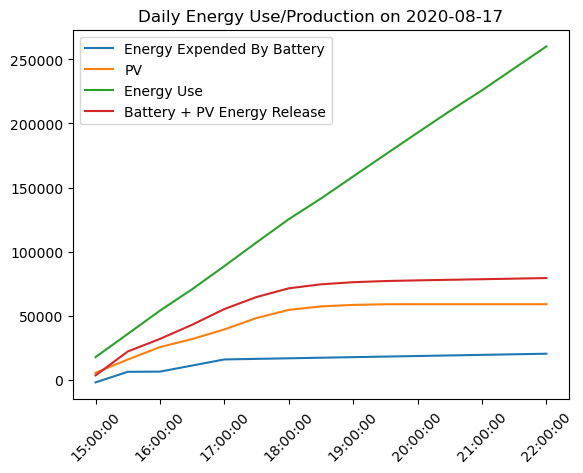

{'Energy at Start': 88785.28333333334,
 'Energy at End': 44053.7,
 'Energy from Battery': 44731.58333333334,
 'Average Need': 26813.327332127894,
 'Average from Battery': 6390.226190476192,
 'Total Need': 201099.95499095926,
 'Excess Need': 156368.37165762592}

index
2020-08-18 22:00:00   -187804.244491
dtype: float64


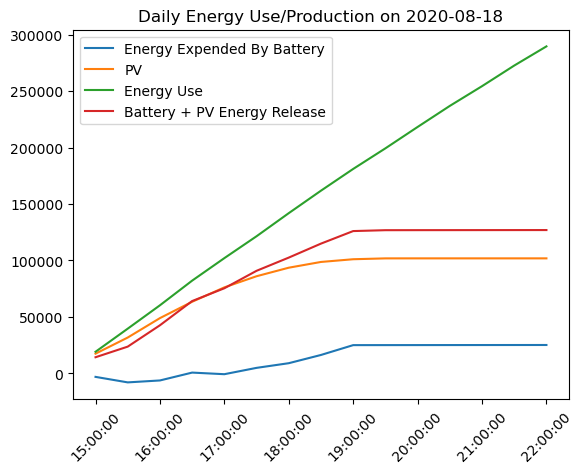

{'Energy at Start': 99195.23333333334,
 'Energy at End': 42698.490476190476,
 'Energy from Battery': 56496.74285714286,
 'Average Need': 25040.56593211704,
 'Average from Battery': 8070.963265306123,
 'Total Need': 187804.24449087784,
 'Excess Need': 131307.50163373497}

index
2020-08-19 22:00:00   -164172.956242
dtype: float64


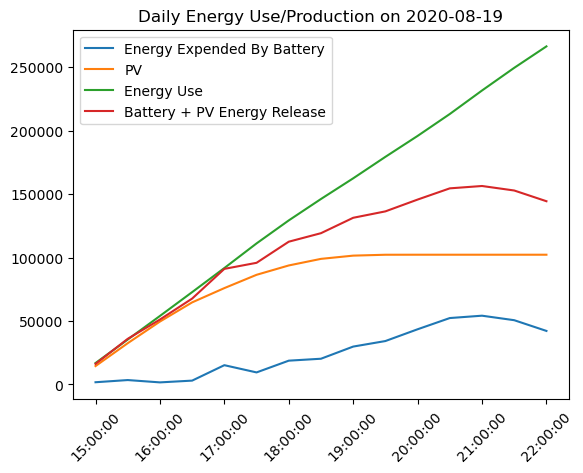

{'Energy at Start': 148552.86666666667,
 'Energy at End': 67680.23333333334,
 'Energy from Battery': 80872.63333333333,
 'Average Need': 21889.72749894884,
 'Average from Battery': 11553.233333333334,
 'Total Need': 164172.95624211628,
 'Excess Need': 83300.32290878295}

index
2020-08-20 22:00:00   -195989.73631
dtype: float64


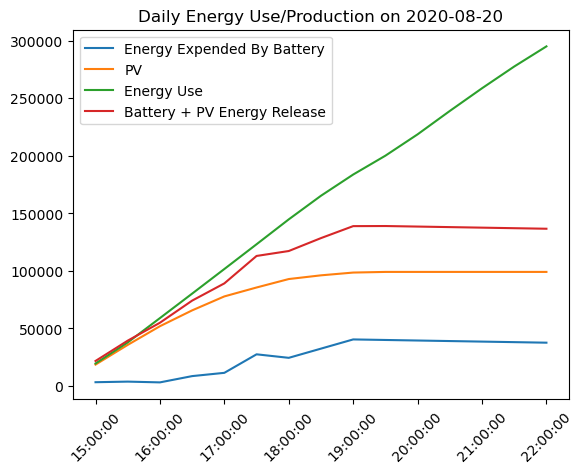

{'Energy at Start': 124916.4,
 'Energy at End': 56214.86666666667,
 'Energy from Battery': 68701.53333333333,
 'Average Need': 26131.9648412874,
 'Average from Battery': 9814.50476190476,
 'Total Need': 195989.73630965556,
 'Excess Need': 127288.20297632224}

index
2020-08-21 22:00:00   -226452.666751
dtype: float64


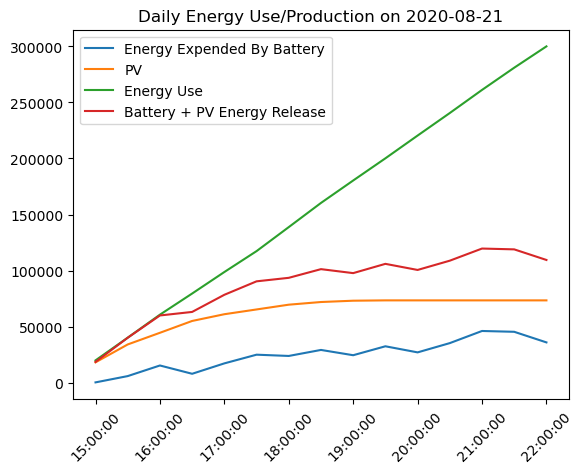

{'Energy at Start': 143241.3,
 'Energy at End': 71935.3,
 'Energy from Battery': 71305.99999999999,
 'Average Need': 30193.688900146484,
 'Average from Battery': 10186.571428571426,
 'Total Need': 226452.6667510986,
 'Excess Need': 155146.6667510986}

index
2020-08-22 22:00:00   -173280.403497
dtype: float64


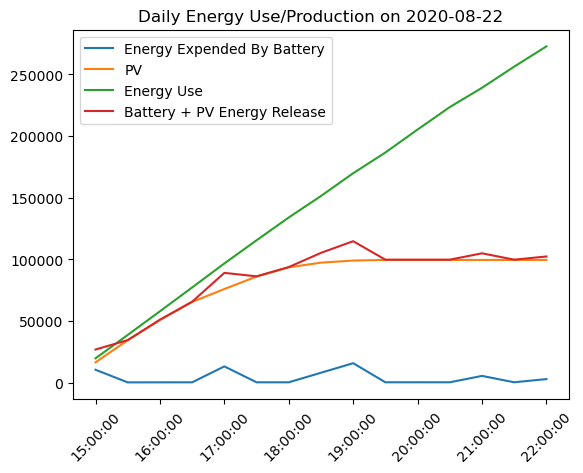

{'Energy at Start': 134597.0,
 'Energy at End': 149750.7,
 'Energy from Battery': -15153.700000000012,
 'Average Need': 23104.053799608017,
 'Average from Battery': -2164.8142857142875,
 'Total Need': 173280.40349706012,
 'Excess Need': 188434.10349706013}

index
2020-08-23 22:00:00   -162124.790803
dtype: float64


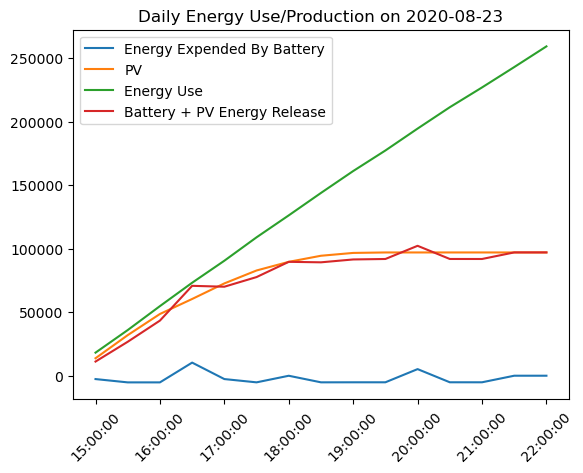

{'Energy at Start': 150230.93333333335,
 'Energy at End': 144949.3,
 'Energy from Battery': 5281.6333333333605,
 'Average Need': 21616.638773795232,
 'Average from Battery': 754.5190476190515,
 'Total Need': 162124.79080346425,
 'Excess Need': 156843.1574701309}

In [80]:
Isl_df=IslandingPower(PowerBal_df)

In [81]:
pd.DataFrame(Isl_df)
#Subtracting PV from Draw and then averaging is different than just taking the total need and dividing it by the 7 hours. Probably some error from left hand rheiman summ to integrate
#Plot Below is 17-23

day 0          day 1          day 2  \
Energy at Start        88785.283333   99195.233333  148552.866667   
Energy at End          44053.700000   42698.490476   67680.233333   
Energy from Battery    44731.583333   56496.742857   80872.633333   
Average Need           26813.327332   25040.565932   21889.727499   
Average from Battery    6390.226190    8070.963265   11553.233333   
Total Need            201099.954991  187804.244491  164172.956242   
Excess Need           156368.371658  131307.501634   83300.322909   

                              day 3          day 4          day 5  \
Energy at Start       124916.400000  143241.300000  134597.000000   
Energy at End          56214.866667   71935.300000  149750.700000   
Energy from Battery    68701.533333   71306.000000  -15153.700000   
Average Need           26131.964841   30193.688900   23104.053800   
Average from Battery    9814.504762   10186.571429   -2164.814286   
Total Need            195989.736310  226452.666751  173280.403497   
Excess Need           127288.202976  155146.666751  188434.103497   

                              day 6  
Energy at Start       150230.933333  
Energy at End         144949.300000  
Energy from Battery     5281.633333  
Average Need           21616.638774  
Average from Battery     754.519048  
Total Need            162124.790803  
Excess Need           156843.157470

# Defunct